# Análisis exploratorio de avisos laborales y postulaciones

1. [Lectura de datos](#1. Lectura de datos)

    - [1.1. Datos sobre los postulantes](#1.1. Datos sobre los postulantes)
    - [1.2. Datos sobre los avisos](#1.2. Datos sobre los avisos)
    - [1.3. Datos sobre las transacciones](#1.3. Datos sobre las transacciones)
    
    
2. [Análisis de los postulantes](#2. Análisis de los postulantes)
    - Sexo de los postulantes
    - Cantidad de postulantes por nivel de educación alcanzado y sexo
    - Cantidad de postulantes por nivel de educación y rango de edad
3. [Análisis de los avisos](#3. Análisis de los avisos)
    - Zonas de CABA con más avisos
    - Áreas de trabajo más populares por zona
    - Ver si hay correlación con ubicación de estaciones de subte, hospitales y facultades
    - Análisis de las descripciones:
    - Rango de edad, nacionalidad, proactividad, estudiantes, residencia en la zona, Office, horarios rotativos/flexibles, PYME
4. [Análisis de las postulaciones](#4. Análisis de las postulaciones)
    - Cantidad de postulaciones por día
    - Rangos horarios con más vistas
    - Rangos horarios con más postulaciones
    - Correlación entre edad, tipo de trabajo, y horario de vistas y de postulaciones
    - Cantidad de vistas de los postulantes antes de cada postulación
    - Variedad de las áreas de trabajo a las que se postulan

## 1. Lectura de datos

Contamos con seis conjuntos de datos que los leemos en sus respectivos *data frames* utilizando Pandas:

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime
from itertools import cycle, islice
import geopy
from geopy.geocoders import Nominatim
import folium
from six.moves import cStringIO as StringIO
from collections import OrderedDict
from bokeh.plotting import figure, show, output_file
from math import log, sqrt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10,5)

In [2]:
# Postulantes
postulantes_educacion = pd.read_csv('./data/fiuba_1_postulantes_educacion.csv', low_memory=False, encoding='utf-8')
postulantes_sexo_y_edad = pd.read_csv('./data/fiuba_2_postulantes_genero_y_edad.csv', low_memory=False, encoding='utf-8')
# Avisos
avisos_online = pd.read_csv('./data/fiuba_5_avisos_online.csv', low_memory=False, encoding='utf-8')
avisos_detalle = pd.read_csv('./data/fiuba_6_avisos_detalle.csv', low_memory=False, encoding='utf-8')
# Transacciones
vistas = pd.read_csv('./data/fiuba_3_vistas.csv', low_memory=False, encoding='utf-8')
postulaciones = pd.read_csv('./data/fiuba_4_postulaciones.csv', low_memory=False, encoding='utf-8')

### 1.1. Datos sobre los postulantes

Tenemos dos *data frames* acerca de los postulantes: uno con información acerca de su sexo y fecha de nacimiento y el otro acerca de su nivel de educación.

In [3]:
postulantes_sexo_y_edad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200888 entries, 0 to 200887
Data columns (total 3 columns):
idpostulante       200888 non-null object
fechanacimiento    196138 non-null object
sexo               200888 non-null object
dtypes: object(3)
memory usage: 4.6+ MB


Pasamos la columna **fechanacimiento** al formato *datetime*:

In [4]:
postulantes_sexo_y_edad['fechanacimiento'] = \
    pd.to_datetime(postulantes_sexo_y_edad['fechanacimiento'], errors='coerce')

El *data frame* **postulantes_sexo_y_edad** tiene un total de 200888 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante
* **fechanacimiento**: año, mes y día de nacimiento del postulante separado por guiones.
* **sexo**: atributo categórico que puede tomar tres valores posibles: *FEM*, *MASC* y *NO_DECLARA*

In [5]:
postulantes_educacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298231 entries, 0 to 298230
Data columns (total 3 columns):
idpostulante    298231 non-null object
nombre          298231 non-null object
estado          298231 non-null object
dtypes: object(3)
memory usage: 6.8+ MB


El *data frame* **postulantes_educacion** tiene un total de 298231 registros con tres columnas:
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **nombre**: atributo categórico que puede tomar los siguientes valores: *Secundario*, *Terciario/Técnico*, *Universitario*, *Posgrado*, *Master*, *Doctorado* y *Otro*.
* **estado**: atributo categórico que puede tomar tres valores posibles: *En Curso*, *Graduado* y *Abandonado*

### 1.2. Datos sobre los avisos

Tenemos dos *data frames* acerca de los avisos: uno con un listado de los que se encuentraban publicados online el 8 de marzo de 2018 y otro con la información detallada de cada aviso.

In [6]:
avisos_online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5028 entries, 0 to 5027
Data columns (total 1 columns):
idaviso    5028 non-null int64
dtypes: int64(1)
memory usage: 39.4 KB


El *data frame* **avisos_online** tiene un total de 5028 registros con una sola columna:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.

In [7]:
avisos_detalle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13534 entries, 0 to 13533
Data columns (total 11 columns):
idaviso                 13534 non-null int64
idpais                  13534 non-null int64
titulo                  13534 non-null object
descripcion             13534 non-null object
nombre_zona             13534 non-null object
ciudad                  47 non-null object
mapacalle               872 non-null object
tipo_de_trabajo         13534 non-null object
nivel_laboral           13534 non-null object
nombre_area             13534 non-null object
denominacion_empresa    13529 non-null object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


El *data frame* **avisos_detalle** tiene un total de 13534  registros con once columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso.
* **idpais**: número entero que representa el código de identificación del país del aviso.
* **titulo**: cadena de caracteres con el nombre del puesto de trabajo.
* **descripcion**: texto de varias líneas con la descripción del aviso en formato HTML.
* **nombre_zona**: cadena de caracteres que puede tener los siguientes valores: *Gran Buenos Aires*, *Capital Federal*, *GBA Oeste* y *Buenos Aires (fuera de GBA)*
* **ciudad**: cadena de caracteres con el nombre de la ciudad del puesto de trabajo.
* **mapacalle**: cadena de caracteres con la dirección del lugar de trabajo.
* **tipo_de_trabajo**: atributo categórico que puede adoptar los siguientes valores: *Full-time*, *Part-time*, *Teletrabajo*, Pasantía*, *Por Horas*, *Temporario*, *Por Contrato*, *Fines de Semana* y *Primer empleo*.
* **nivel_laboral**: atributo categórico que puede adoptar los siguientes valores: *Senior / Semi-Senior*, *Junior*, *Jefe / Supervisor / Responsable*, *Gerencia / Alta Gerencia / Dirección* y *Otro*.
* **nombre_area**: cadena de caracteres que representa el área de trabajo, como por ejemplo: *Ventas*, *Contabilidad* o *Recursos Humanos*.
* **denominacion_empresa**: nombre de la empresa que publicó el aviso.

### 1.3 Datos sobre las transacciones

Tenemos dos *data frames* con información de dos hechos a partir de las dimensiones anteriores. El *data frame* vistas contiene el detalle de todas las veces que los postulantes visualizaron los diversos avisos y el *data frame* postulaciones registra quiénes se postularon a qué avisos y cuándo.

In [8]:
vistas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961897 entries, 0 to 961896
Data columns (total 3 columns):
idAviso         961897 non-null int64
timestamp       961897 non-null object
idpostulante    961897 non-null object
dtypes: int64(1), object(2)
memory usage: 22.0+ MB


El *data frame* **vistas** tiene un total de 961897 registros con tres columnas:
* **idAviso**: cadena de caracteres que representa el código de identificación del aviso visto.
* **timestamp**: año, mes día y hora exacta en la que se produjo la vista del aviso.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante que vio el aviso.

In [9]:
postulaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3401623 entries, 0 to 3401622
Data columns (total 3 columns):
idaviso             int64
idpostulante        object
fechapostulacion    object
dtypes: int64(1), object(2)
memory usage: 77.9+ MB


El *data frame* **postulaciones** tiene un total de 3401623 registros con tres columnas:
* **idaviso**: cadena de caracteres que representa el código de identificación del aviso al cual se realizó la postulación.
* **idpostulante**: cadena de caracteres que representa el código de identificación del postulante.
* **fechapostulacion**: año, mes día y hora exacta en la que se produjo la postulación.

Pasamos las columnas de fechas al formato *datetime*:

In [10]:
vistas['timestamp'] = pd.to_datetime(vistas['timestamp'], errors='coerce')
postulaciones['fechapostulacion'] = \
    pd.to_datetime(postulaciones['fechapostulacion'], errors='coerce')

## 2. Análisis de los postulantes

In [11]:
def categorizar_sexo(x):
    if((x is np.nan) | (x == 'NO_DECLARA')):
        return 'No declara'
    if(x == 'FEM'):
        return 'Femenino'
    if(x == 'MASC'):
        return 'Masculino'
postulantes_sexo_y_edad['sexo'] = postulantes_sexo_y_edad['sexo'].apply(lambda x: categorizar_sexo(x))
postulantes_sexo_y_edad.groupby('sexo').count()

,idpostulante,fechanacimiento
sexo,,
Femenino,101981,101674
Masculino,94339,94013
No declara,4568,444


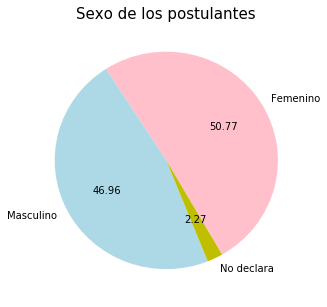

In [12]:
sexo = postulantes_sexo_y_edad['sexo'].value_counts()
plt = sexo.plot.pie(fontsize = 10, figsize = (5, 5), startangle = 300, autopct = '%.2f',
              title = 'Sexo de los postulantes', colors = ['pink','lightblue','y']);
plt.set_title('Sexo de los postulantes', fontsize = 15);
plt.axis('off');

### Edades de los postulantes

In [13]:
def calcular_edad(fecha_nacimiento):
    hoy = datetime.date.today()
    return hoy.year - fecha_nacimiento.year - \
        ((hoy.month, hoy.day) < (fecha_nacimiento.month, fecha_nacimiento.day))

postulantes_sexo_y_edad['edad'] = postulantes_sexo_y_edad['fechanacimiento'].apply(lambda x: calcular_edad(x))
postulantes_sexo_y_edad['edad'] = postulantes_sexo_y_edad['edad'].fillna(0.0).astype(int)

In [14]:
sexo_edad = postulantes_sexo_y_edad.loc[((postulantes_sexo_y_edad['edad'] <= 65) & (postulantes_sexo_y_edad['edad'] >= 16)\
    & (postulantes_sexo_y_edad['sexo'] != 'No declara')),:].groupby(['edad','sexo'])\
    .count().reset_index().pivot(index='edad',columns='sexo',values='idpostulante')

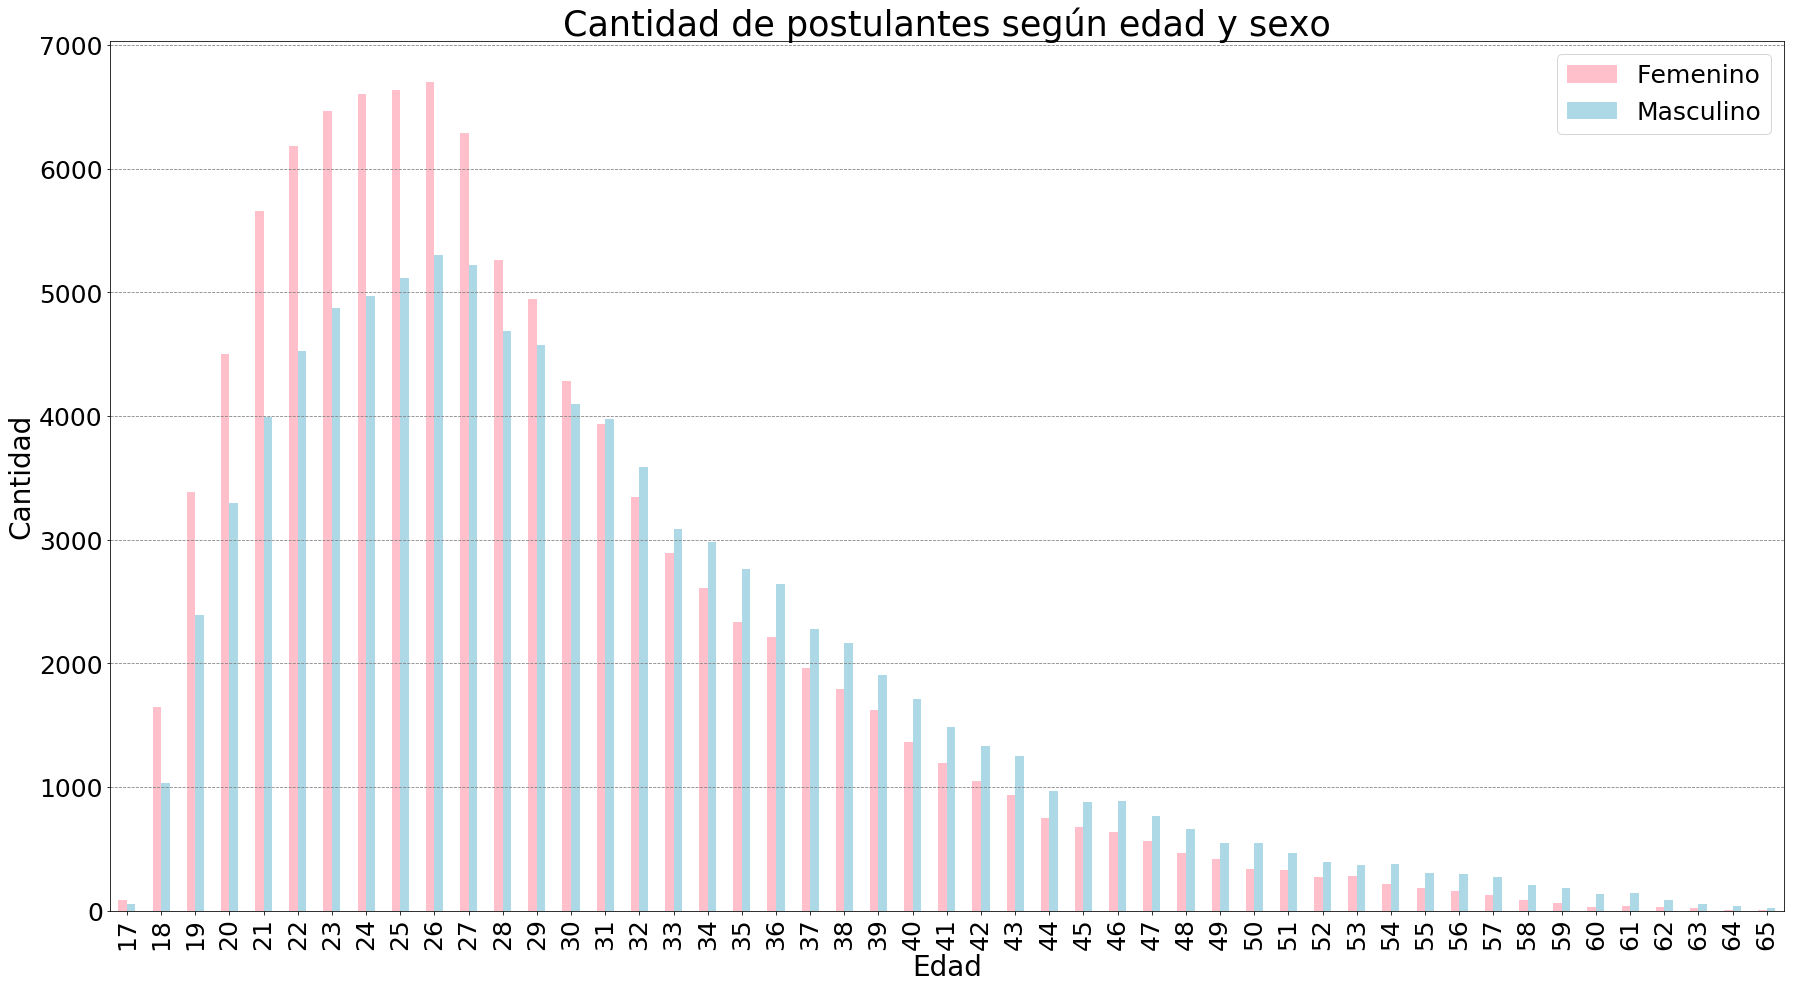

In [15]:
plt = sexo_edad.plot(kind = 'bar',color = ['pink','lightblue'], figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad', fontsize = 28)
plt.set_title('Cantidad de postulantes según edad y sexo', fontsize = 35)
plt.grid(linestyle = 'dashed', color= 'gray')
plt.legend(fontsize = 25)
plt.xaxis.grid(False);

En el gráfico se puede apreciar que hay más postulantes mujeres que varones hasta los 30 años de edad y a partir de los 31 es al revés. Además podemos ver que la mayor cantidad de postulantes en general son jóvenes, entre 20 y 30 años.

### Nivel de estudios alcanzados por sexo y por edad

Agregamos una nueva columna para categorizar el nivel de estudios alcanzado en donde ponemos a 'Posgrado', 'Master' y 'Doctorado' en la categoría 'Posgrado' e ignoramos por ahora el estado:

In [16]:
def categorizar_estudios(x):
    if((x is np.nan) | (x == 'Otro')):
        return 0
    if(x == 'Secundario'):
        return 1
    if(x == 'Terciario/Técnico'):
        return 2
    if(x == 'Universitario'):
        return 3
    if((x == 'Posgrado') | (x == 'Master') | (x == 'Doctorado')):
        return 4

postulantes_educacion['nivel_alcanzado'] = postulantes_educacion['nombre']\
    .apply(lambda x: categorizar_estudios(x))
postulantes_educacion.head()

,idpostulante,nombre,estado,nivel_alcanzado
0,NdJl,Posgrado,En Curso,4
1,8BkL,Universitario,En Curso,3
2,1d2B,Universitario,En Curso,3
3,NPBx,Universitario,En Curso,3
4,NPBx,Master,En Curso,4


Unimos ambos *data frames* de los postulantes:

In [17]:
postulantes = pd.merge(postulantes_sexo_y_edad, postulantes_educacion, on='idpostulante', how='outer')
postulantes.head()

,idpostulante,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado
0,NM5M,1970-12-03,Femenino,47,Secundario,Graduado,1.0
1,5awk,1962-12-04,Femenino,55,Universitario,Graduado,3.0
2,5awk,1962-12-04,Femenino,55,Terciario/Técnico,Graduado,2.0
3,ZaO5,1978-08-10,Femenino,39,Terciario/Técnico,Graduado,2.0
4,ZaO5,1978-08-10,Femenino,39,Universitario,Abandonado,3.0


Ignoraremos por ahora el estado de los estudios y nos quedamos únicamente con el nivel más alto, independientemente de si lo haya finalizado o no.

In [18]:
postulantes = postulantes.sort_values('nivel_alcanzado', ascending=False).drop_duplicates('idpostulante')

In [19]:
nivel_sexo = postulantes.groupby(['sexo','nivel_alcanzado']).count().reset_index()\
    .drop(['fechanacimiento','nombre','estado'],axis=1)\
    .pivot(index='nivel_alcanzado', columns='sexo', values='idpostulante')
nivel_sexo

sexo,Femenino,Masculino,No declara
nivel_alcanzado,,,
0.0,579,731,28
1.0,28060,33162,1189
2.0,15593,11480,356
3.0,48298,38455,1085
4.0,4473,5188,75


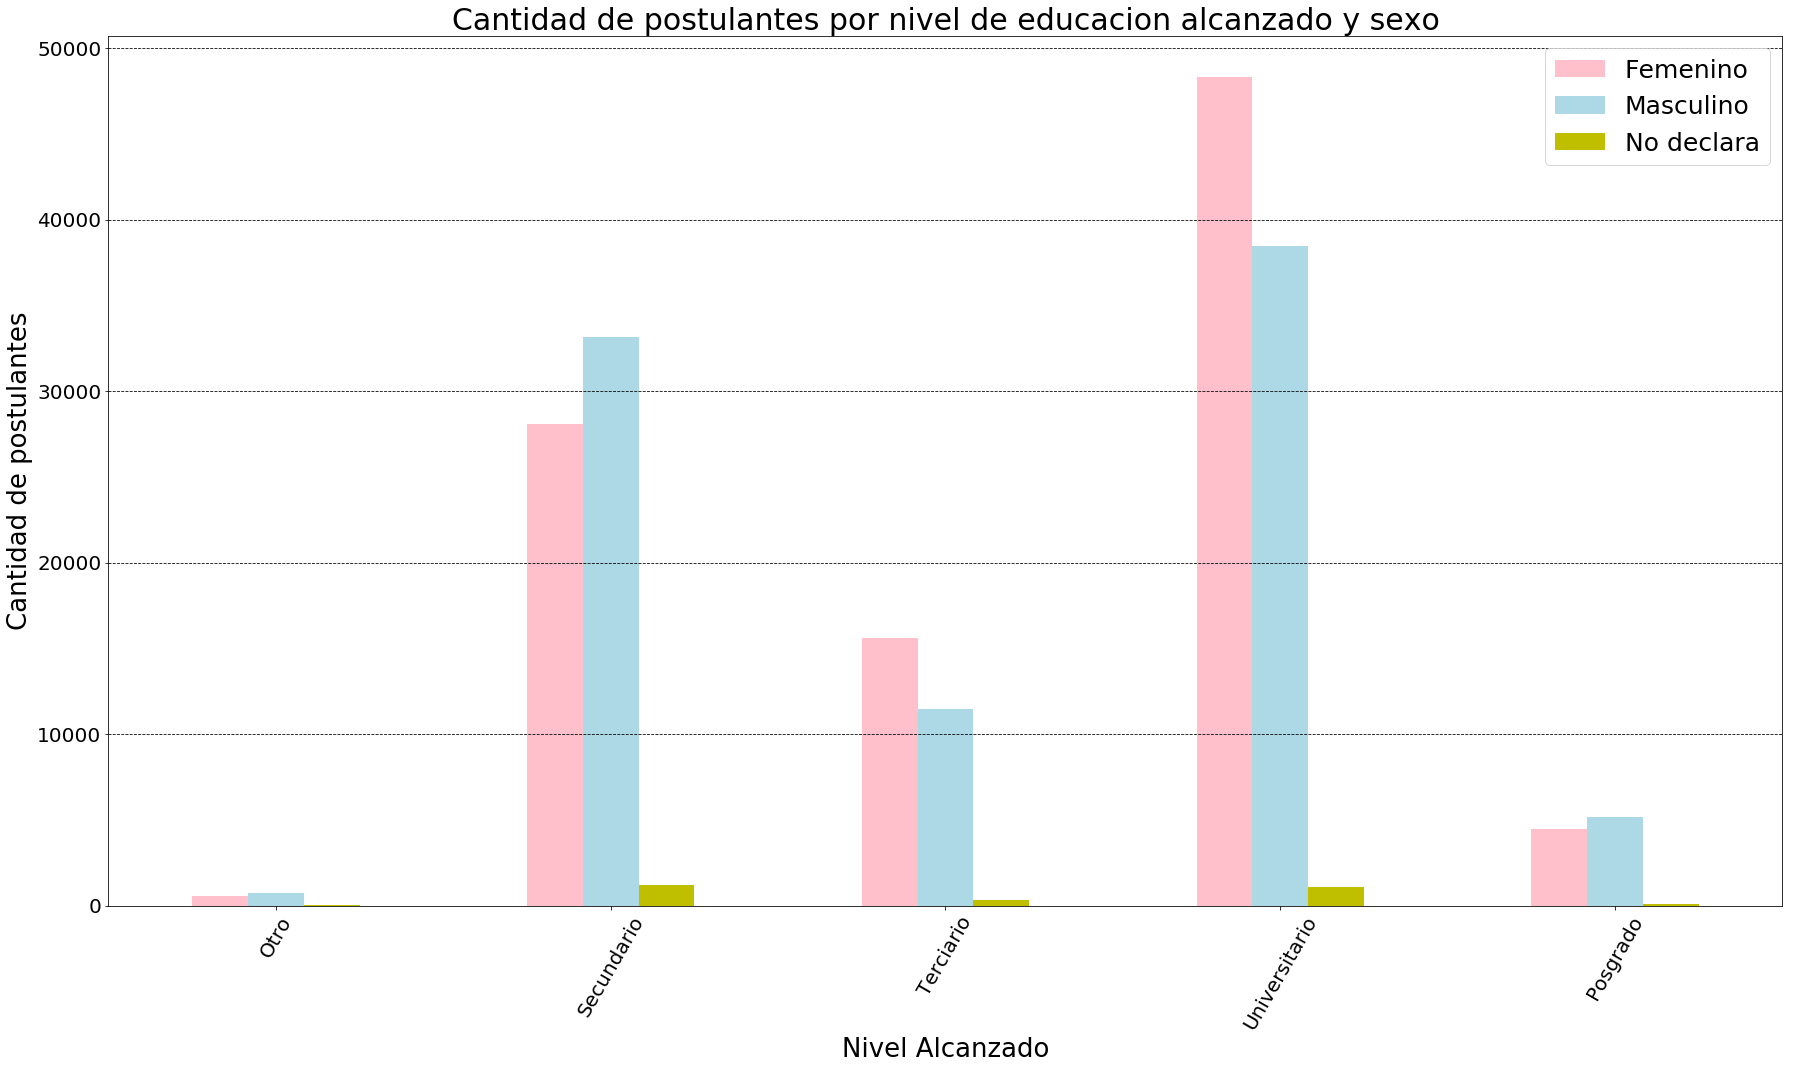

In [20]:
plt = nivel_sexo.plot(kind = 'bar', color = ['pink','lightblue','y'], figsize=(30,16), rot=60)
plt.set_xlabel('Nivel Alcanzado', fontsize = 26)
plt.set_ylabel('Cantidad de postulantes', fontsize = 26)
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y sexo', fontsize = 30)
plt.set_xticklabels(('Otro', 'Secundario','Terciario','Universitario','Posgrado'), fontsize = 20)
plt.set_yticklabels((0,10000,20000,30000,40000,50000), fontsize = 20)
plt.grid(linestyle = 'dashed', color = 'black')
plt.legend(fontsize = 25)
plt.xaxis.grid(False);

In [21]:
def categorizar_edad(x):
    if (x <= 21):
        return '21 o menos'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    if (x <= 50):
        return '41 a 50'
    return '51 o más'

postulantes['rango_edad'] = postulantes['edad'].apply(lambda x: categorizar_edad(x))

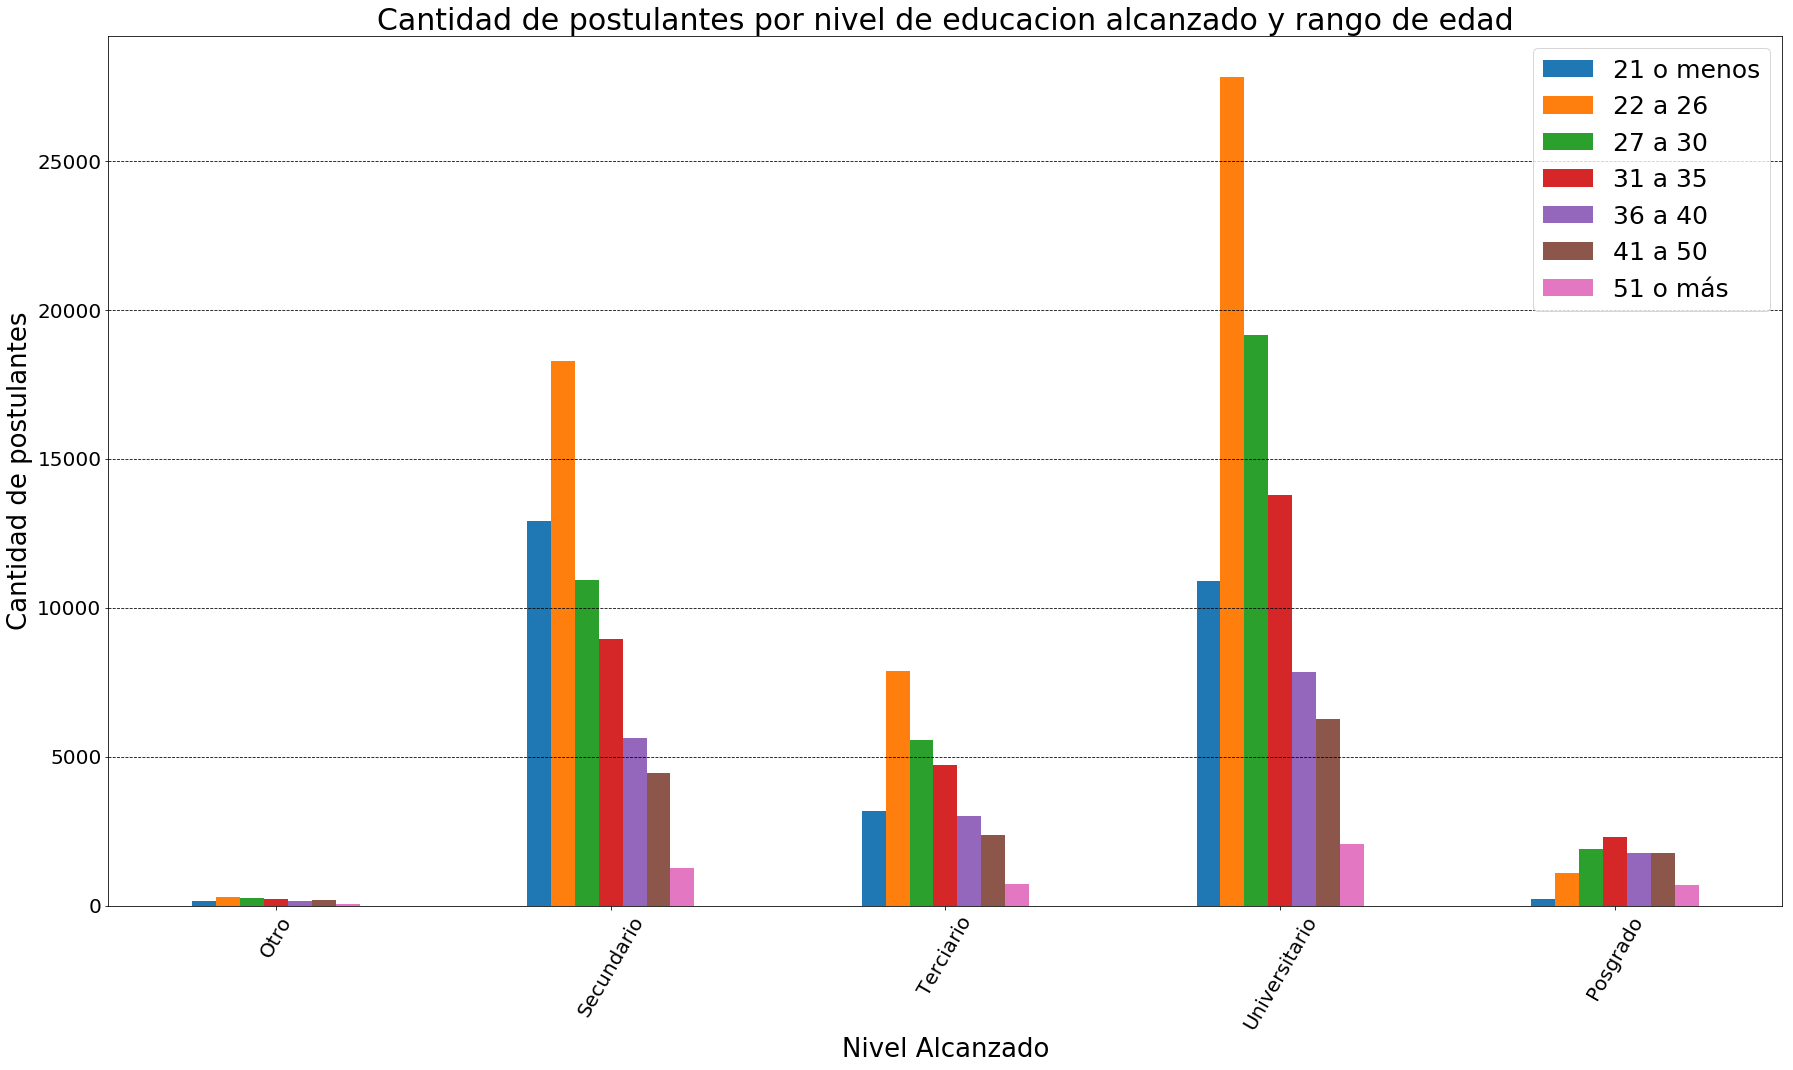

In [22]:
plt = postulantes.groupby(['nivel_alcanzado','rango_edad']).size().to_frame('cant').reset_index()\
    .pivot(index='nivel_alcanzado',columns='rango_edad',values='cant')\
    .plot(kind='bar', figsize=(30,16), rot=60)
plt.set_xlabel('Nivel Alcanzado', fontsize = 26)
plt.set_ylabel('Cantidad de postulantes', fontsize = 26)
plt.set_title('Cantidad de postulantes por nivel de educacion alcanzado y rango de edad', fontsize = 30)
plt.set_xticklabels(('Otro', 'Secundario','Terciario','Universitario','Posgrado'), fontsize = 20)
plt.set_yticklabels((0,5000,10000,15000,20000,25000), fontsize = 20)
plt.legend(fontsize = 25)
plt.grid(linestyle = 'dashed', color = 'black')
plt.xaxis.grid(False);

## 3. Análisis de los avisos

### Ubicación geográfica de las empresas

In [23]:
def corregir_direcciones(direccion):
    if direccion is not pd.np.nan:
        direccion = direccion.replace("Pres.", "Presidente")
        direccion = direccion.replace("moteagudo","Monteagudo")
        direccion = direccion.replace("Belgarno","Belgrano")
        direccion = direccion.replace("Av","Avenida")
        direccion = direccion.replace("nro","")
        direccion = direccion.replace("Gdor.","Gobernador")
        direccion = direccion.replace("piso","")
        direccion = direccion.replace("Piso","")
        direccion = direccion.replace("Int","Intendente")
        direccion = direccion + " Buenos Aires Argentina"
    return direccion

avisos_detalle['mapacalle'] = avisos_detalle['mapacalle'].apply(lambda x: corregir_direcciones(x))

In [24]:
direcciones = avisos_detalle.groupby(['denominacion_empresa','mapacalle']).count().reset_index()
direcciones.drop(['idaviso','idpais','titulo','descripcion','nombre_zona','ciudad',\
           'tipo_de_trabajo','nivel_laboral','nombre_area'], axis=1, inplace=True)

direcciones.head()

,denominacion_empresa,mapacalle
0,A. E. Ponce Ingeniería S.A.,OLAZABAL 1515 Buenos Aires Argentina
1,ACCIONA IT,Barracas Buenos Aires Argentina
2,ACCIONA IT,Paysandú 1800 Buenos Aires Argentina
3,ADEPCON,Sánchez de Loria 2395 Buenos Aires Argentina
4,ADHEFULL SA,Superí 2100 Buenos Aires Argentina


In [26]:
from geopy.exc import GeocoderTimedOut
def obtener_coordenadas(direccion):
    geolocator = Nominatim(timeout=None)
    try:
        lugar = geolocator.geocode(direccion)
    except GeocoderTimedOut as e:
        lugar = None
    return False if lugar is None else [lugar.latitude, lugar.longitude]

direcciones['coordenadas'] = direcciones['mapacalle'].apply(lambda x: obtener_coordenadas(x))
direcciones.head()

,denominacion_empresa,mapacalle,coordenadas
0,A. E. Ponce Ingeniería S.A.,OLAZABAL 1515 Buenos Aires Argentina,"[-34.55491593, -58.449656085]"
1,ACCIONA IT,Barracas Buenos Aires Argentina,"[-34.6452854, -58.3875619]"
2,ACCIONA IT,Paysandú 1800 Buenos Aires Argentina,"[-34.6007752, -58.4572081]"
3,ADEPCON,Sánchez de Loria 2395 Buenos Aires Argentina,"[-34.6379437959184, -58.4113198163265]"
4,ADHEFULL SA,Superí 2100 Buenos Aires Argentina,"[-34.568073, -58.466527]"


In [27]:
map = folium.Map(location=[-34.617, -58.44], zoom_start=11)
for coordenada in direcciones.coordenadas:
    if (coordenada):
        folium.RegularPolygonMarker(coordenada, radius=6, number_of_sides=9).add_to(map)

map

### Empresas y áreas de trabajo con más avisos

In [28]:
top15_empresas = avisos_detalle.groupby('denominacion_empresa').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

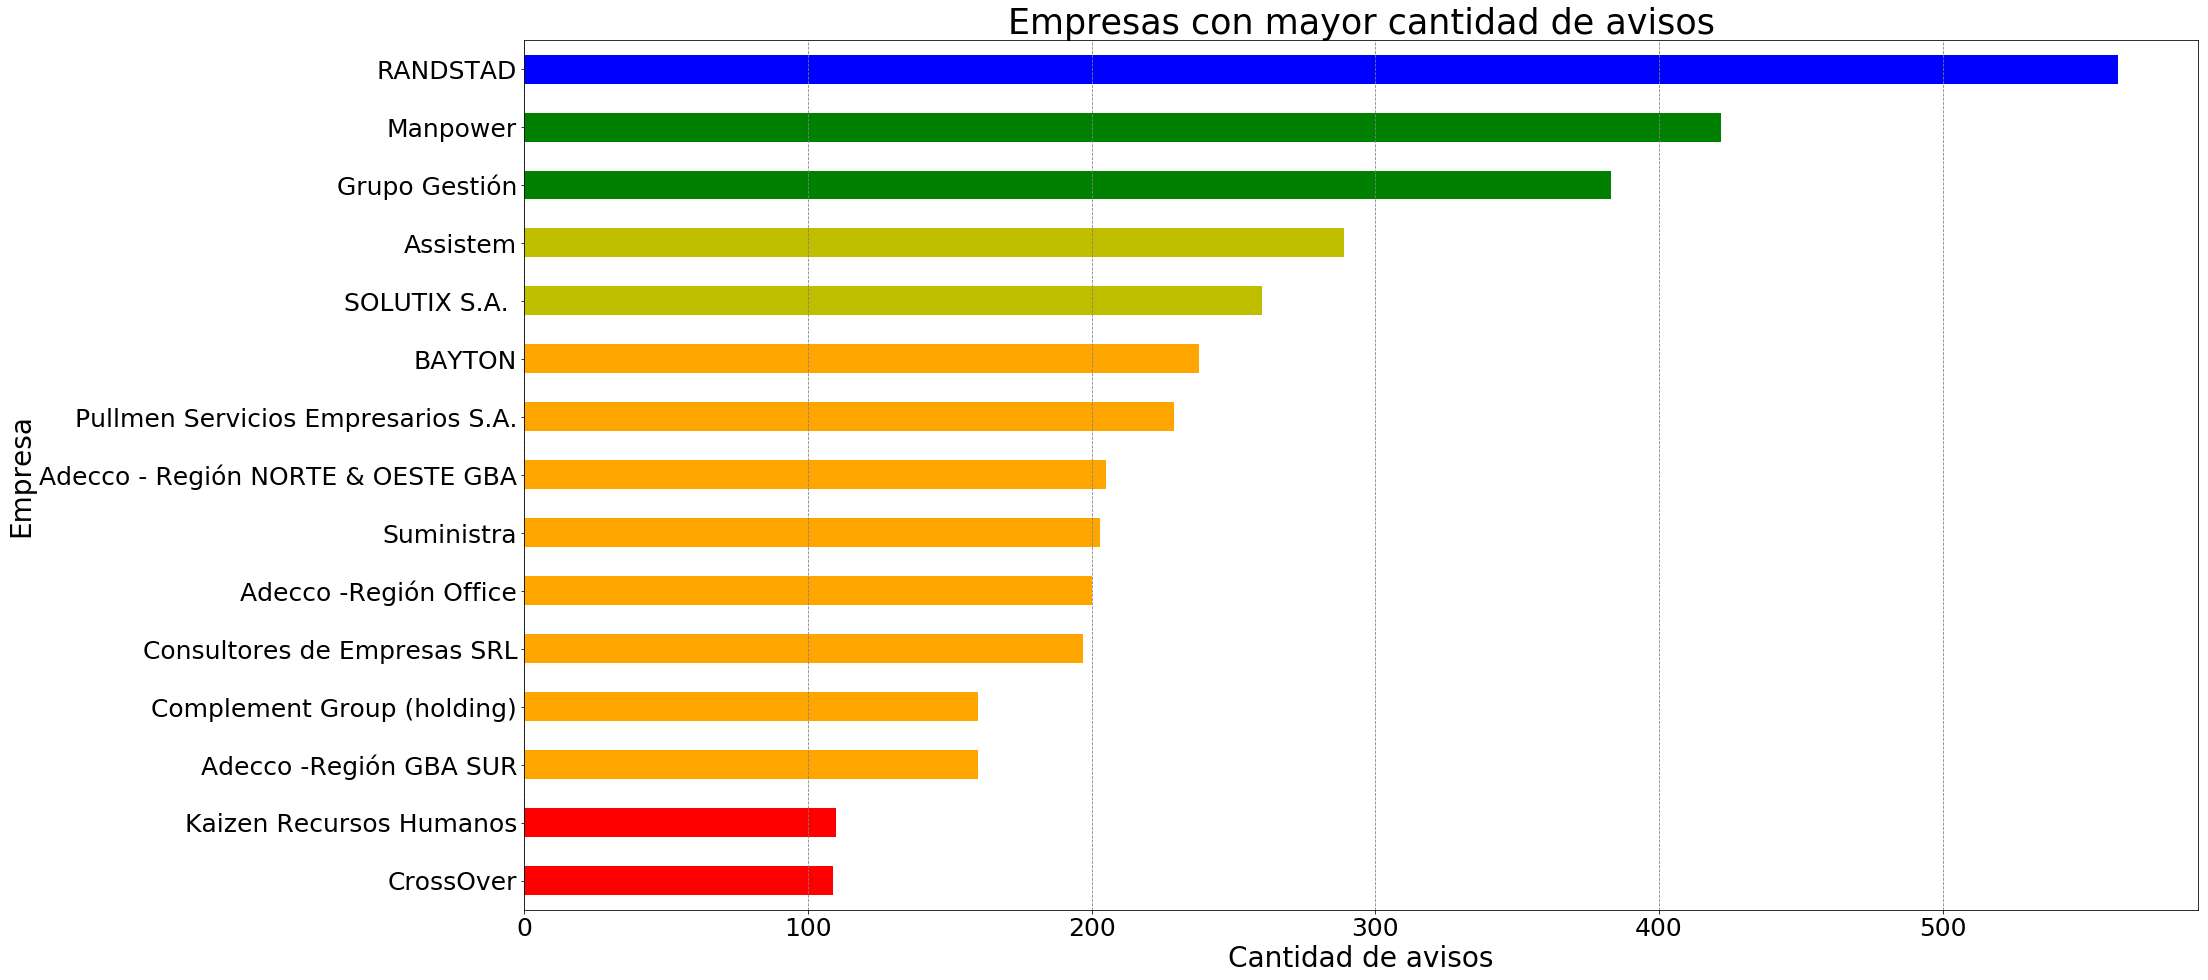

In [29]:
CUTLIST = [0,150,250,350,500,700]
LABELSLIST = ['r','orange','y','g', 'b']

plt = top15_empresas.set_index('denominacion_empresa').sort_values(by = 'cantidad')
colors = pd.cut(plt['cantidad'], CUTLIST, labels=LABELSLIST)

plt = plt['cantidad'].plot(kind = 'barh', color = colors, figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Cantidad de avisos', fontsize = 28)
plt.set_ylabel('Empresa', fontsize = 28)
plt.set_title('Empresas con mayor cantidad de avisos', fontsize = 35)
plt.grid(linestyle = 'dashed', color = 'gray')
plt.yaxis.grid(False);

In [30]:
top15_areas = avisos_detalle.groupby('nombre_area').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

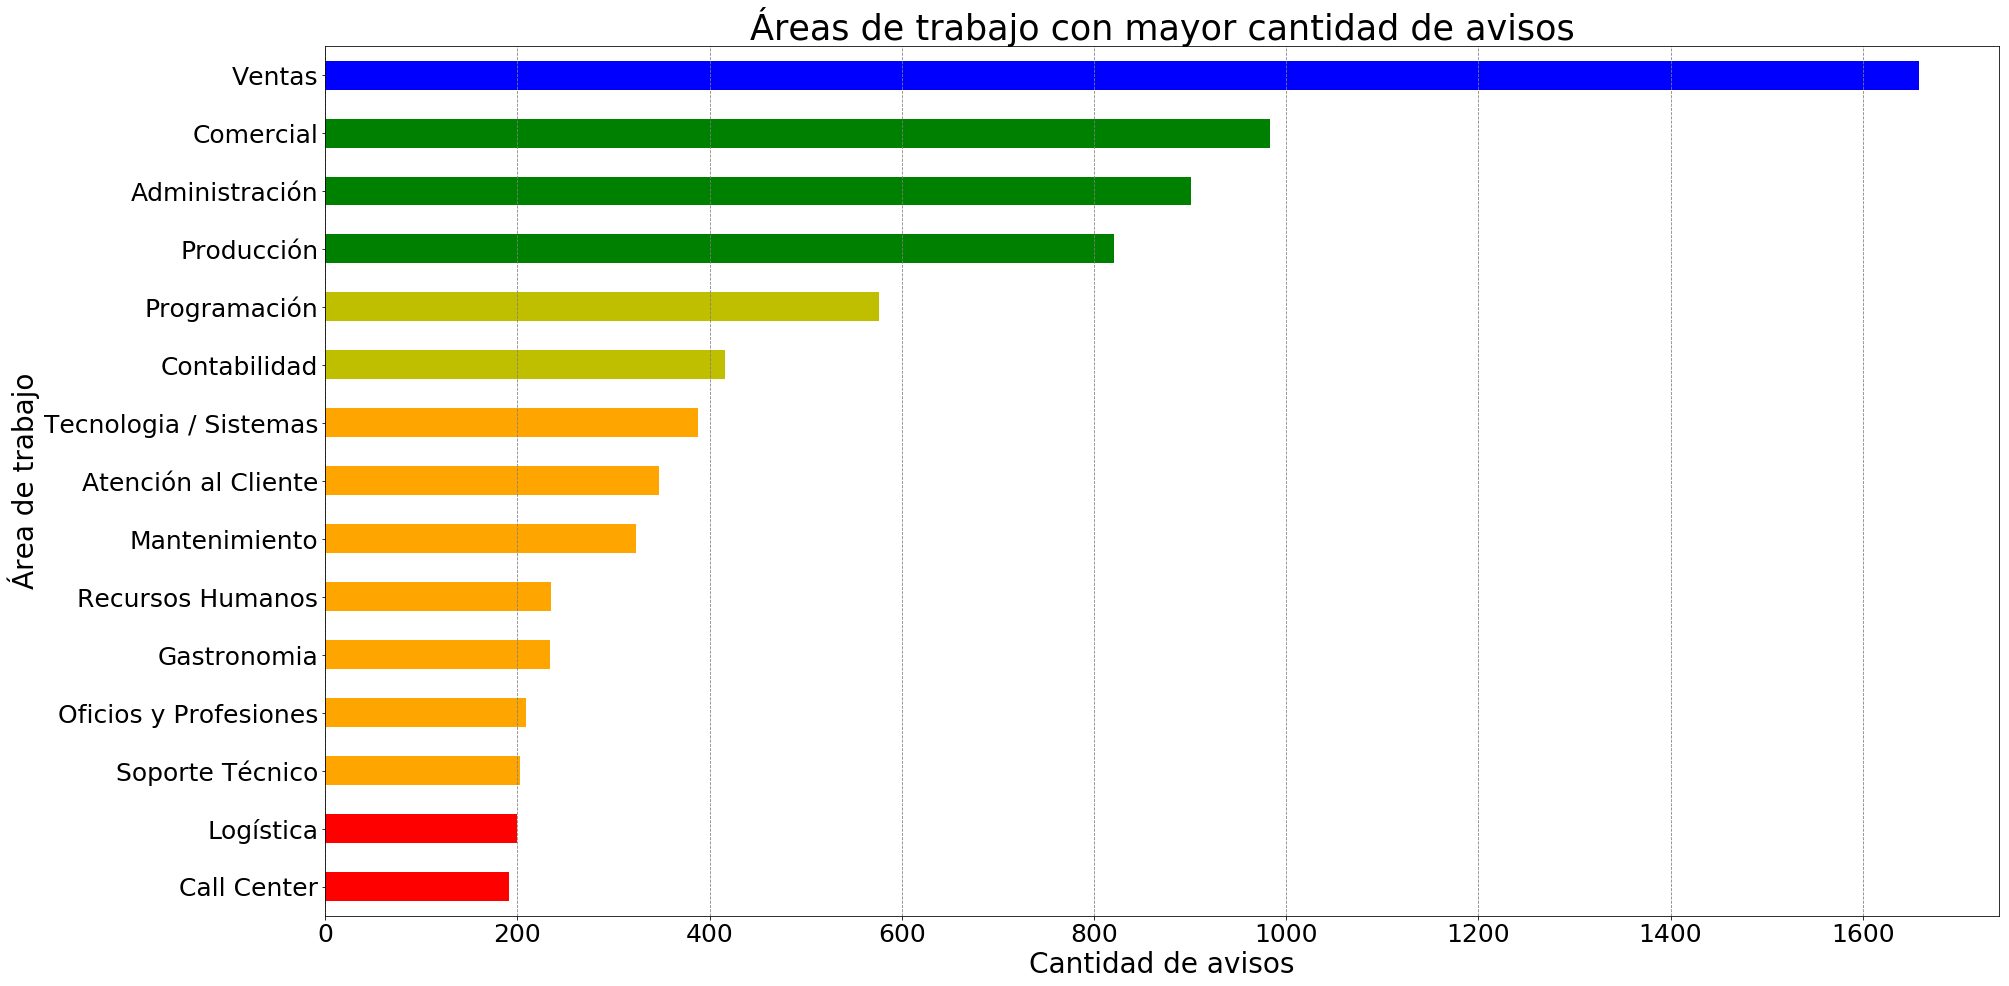

In [31]:
CUTLIST = [0,200,400,800,1000,1700]
LABELSLIST = ['r','orange','y','g', 'b']

plt = top15_areas.set_index('nombre_area').sort_values(by = 'cantidad')
colors = pd.cut(plt['cantidad'], CUTLIST, labels=LABELSLIST)

plt = plt['cantidad'].plot(kind = 'barh', color = colors, figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Cantidad de avisos', fontsize = 28)
plt.set_ylabel('Área de trabajo', fontsize = 28)
plt.set_title('Áreas de trabajo con mayor cantidad de avisos', fontsize = 35)
plt.grid(linestyle='dashed', color = 'gray')
plt.yaxis.grid(False);

Tomaremos las quince áreas más frecuentes entre las 15 empresas con mayor cantidad de avisos:

In [32]:
top15_areas_e = pd.merge(top15_empresas, avisos_detalle, how='inner', on='denominacion_empresa')\
    .groupby('nombre_area').size()\
    .sort_values(ascending=False).head(15).to_frame('cantidad').reset_index()

In [33]:
areas_empresas = pd.merge(top15_empresas, avisos_detalle, how='inner', on='denominacion_empresa')
areas_empresas = pd.merge(top15_areas_e, areas_empresas, how='inner', on='nombre_area')
areas_empresas.rename(index=str, columns={"denominacion_empresa": "Empresa", "nombre_area": "Área de trabajo"}, inplace=True)
areas_empresas = areas_empresas.groupby(['Empresa','Área de trabajo']).count().reset_index()\
    .pivot(index='Empresa',columns='Área de trabajo',values='cantidad_x')
areas_empresas.fillna(0,inplace=True)

In [34]:
areas_empresas = areas_empresas.reset_index()
areas_empresas = areas_empresas.loc[areas_empresas.Empresa.str.contains('SOLUTIX') == False,:]\
    .set_index('Empresa')

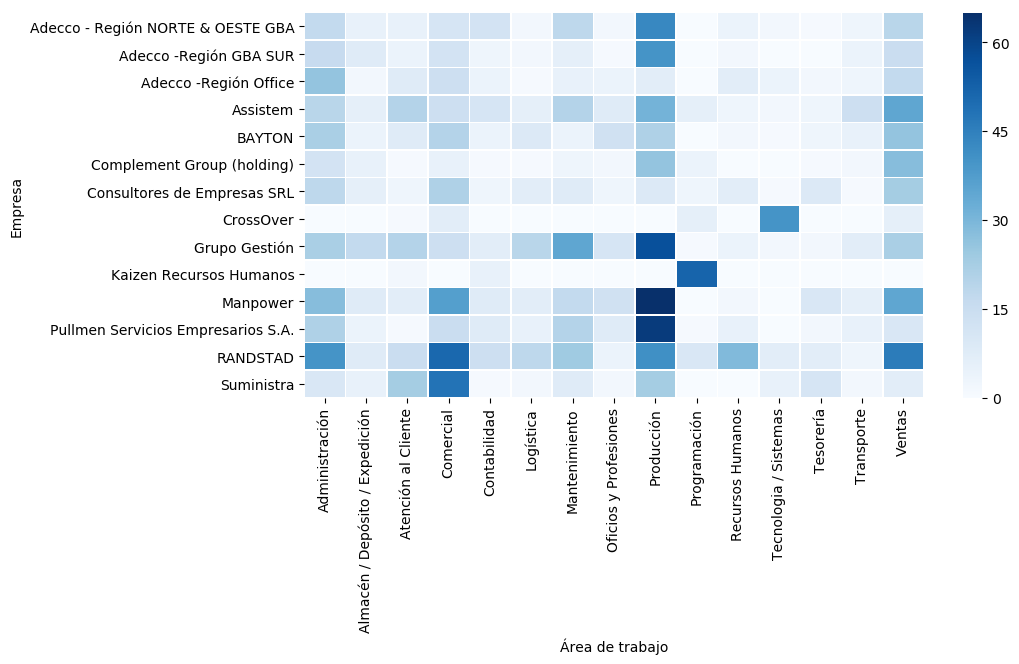

In [43]:
sns.heatmap(areas_empresas, annot=False, linewidths=.5, cmap='Blues');

## 4. Análisis de las vistas y postulaciones

### Cantidad de postulaciones por día

In [44]:
postulaciones['num_dia'] = postulaciones['fechapostulacion'].dt.weekday.map(\
                        pd.Series('0 1 2 3 4 5 6'.split()))
postulaciones['num_dia'] = postulaciones.num_dia.apply(pd.to_numeric)
postulaciones['num_mes'] = postulaciones['fechapostulacion'].dt.month
postulaciones['num_semana'] = postulaciones['fechapostulacion'].dt.weekofyear
postulaciones.head()

,idaviso,idpostulante,fechapostulacion,num_dia,num_mes,num_semana
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4


In [45]:
postulaciones_dias = postulaciones.num_dia.value_counts().to_frame().reset_index().sort_values('index', ascending=False)
postulaciones_dias.rename(index=str, columns={"index": "dia", "num_dia": "cantidad"}, inplace=True)

In [46]:
postulaciones_dias['dia'] = postulaciones_dias['dia'].map(pd.Series('Lunes Martes Miércoles Jueves Viernes Sábado Domingo'.split()))
postulaciones_dias.set_index('dia', inplace=True)
postulaciones_dias

,cantidad
dia,
Domingo,226857
Sábado,217331
Viernes,446698
Jueves,506163
Miércoles,677836
Martes,658428
Lunes,668310


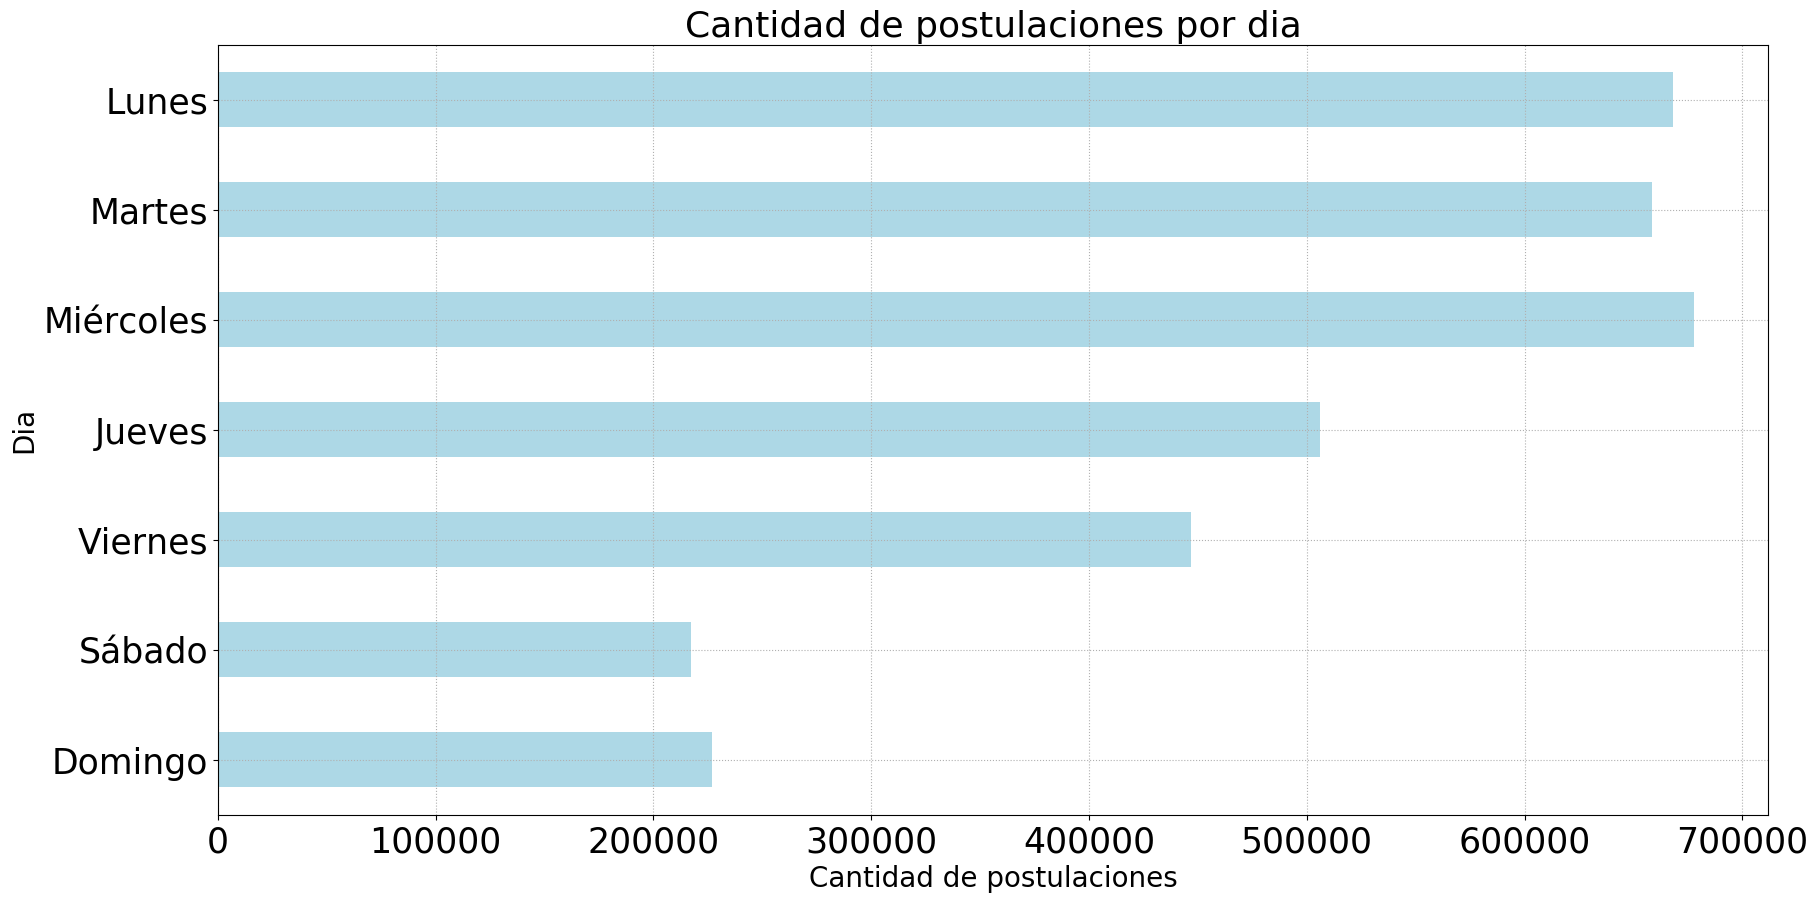

In [47]:
my_colors = list(islice(cycle(['lightblue', 'r', 'pink', 'y', 'orange', 'g', 'b']), None, len(postulaciones_dias)))

plot = postulaciones_dias.plot(kind='barh',figsize=(20,10), fontsize=25, color=my_colors, legend=False)
plot.set_title('Cantidad de postulaciones por dia', fontsize = 26)
plot.set_xlabel('Cantidad de postulaciones', fontsize = 20)
plot.set_ylabel('Dia', fontsize = 20)
plot.grid(linestyle='dotted');

### Rangos horarios con más vistas

In [48]:
vistas['hora'] = vistas['timestamp'].dt.hour
vistas.head()

,idAviso,timestamp,idpostulante,hora
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,18
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR,18
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd,18
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv,18
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP,18


In [49]:
vistas.rename(index=str, columns={"idAviso": "idaviso"}, inplace=True)
#vis_avi = pd.merge(vistas, avisos_detalle, on='idaviso', how='inner')
vis_avi = pd.merge(vistas,postulantes,on = 'idpostulante',how='inner')
vis_avi.head()

,idaviso,timestamp,idpostulante,hora,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado,rango_edad
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,18,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
1,1112301574,2018-02-27 16:28:37.162,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
2,1112319451,2018-02-27 16:26:31.101,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
3,1112326950,2018-02-27 16:28:43.417,YjVJQ6Z,16,1991-11-16,Masculino,26,Universitario,Abandonado,3.0,22 a 26
4,1112263876,2018-02-23 18:38:14.296,BmVpYoR,18,1989-12-08,Masculino,28,Universitario,En Curso,3.0,27 a 30


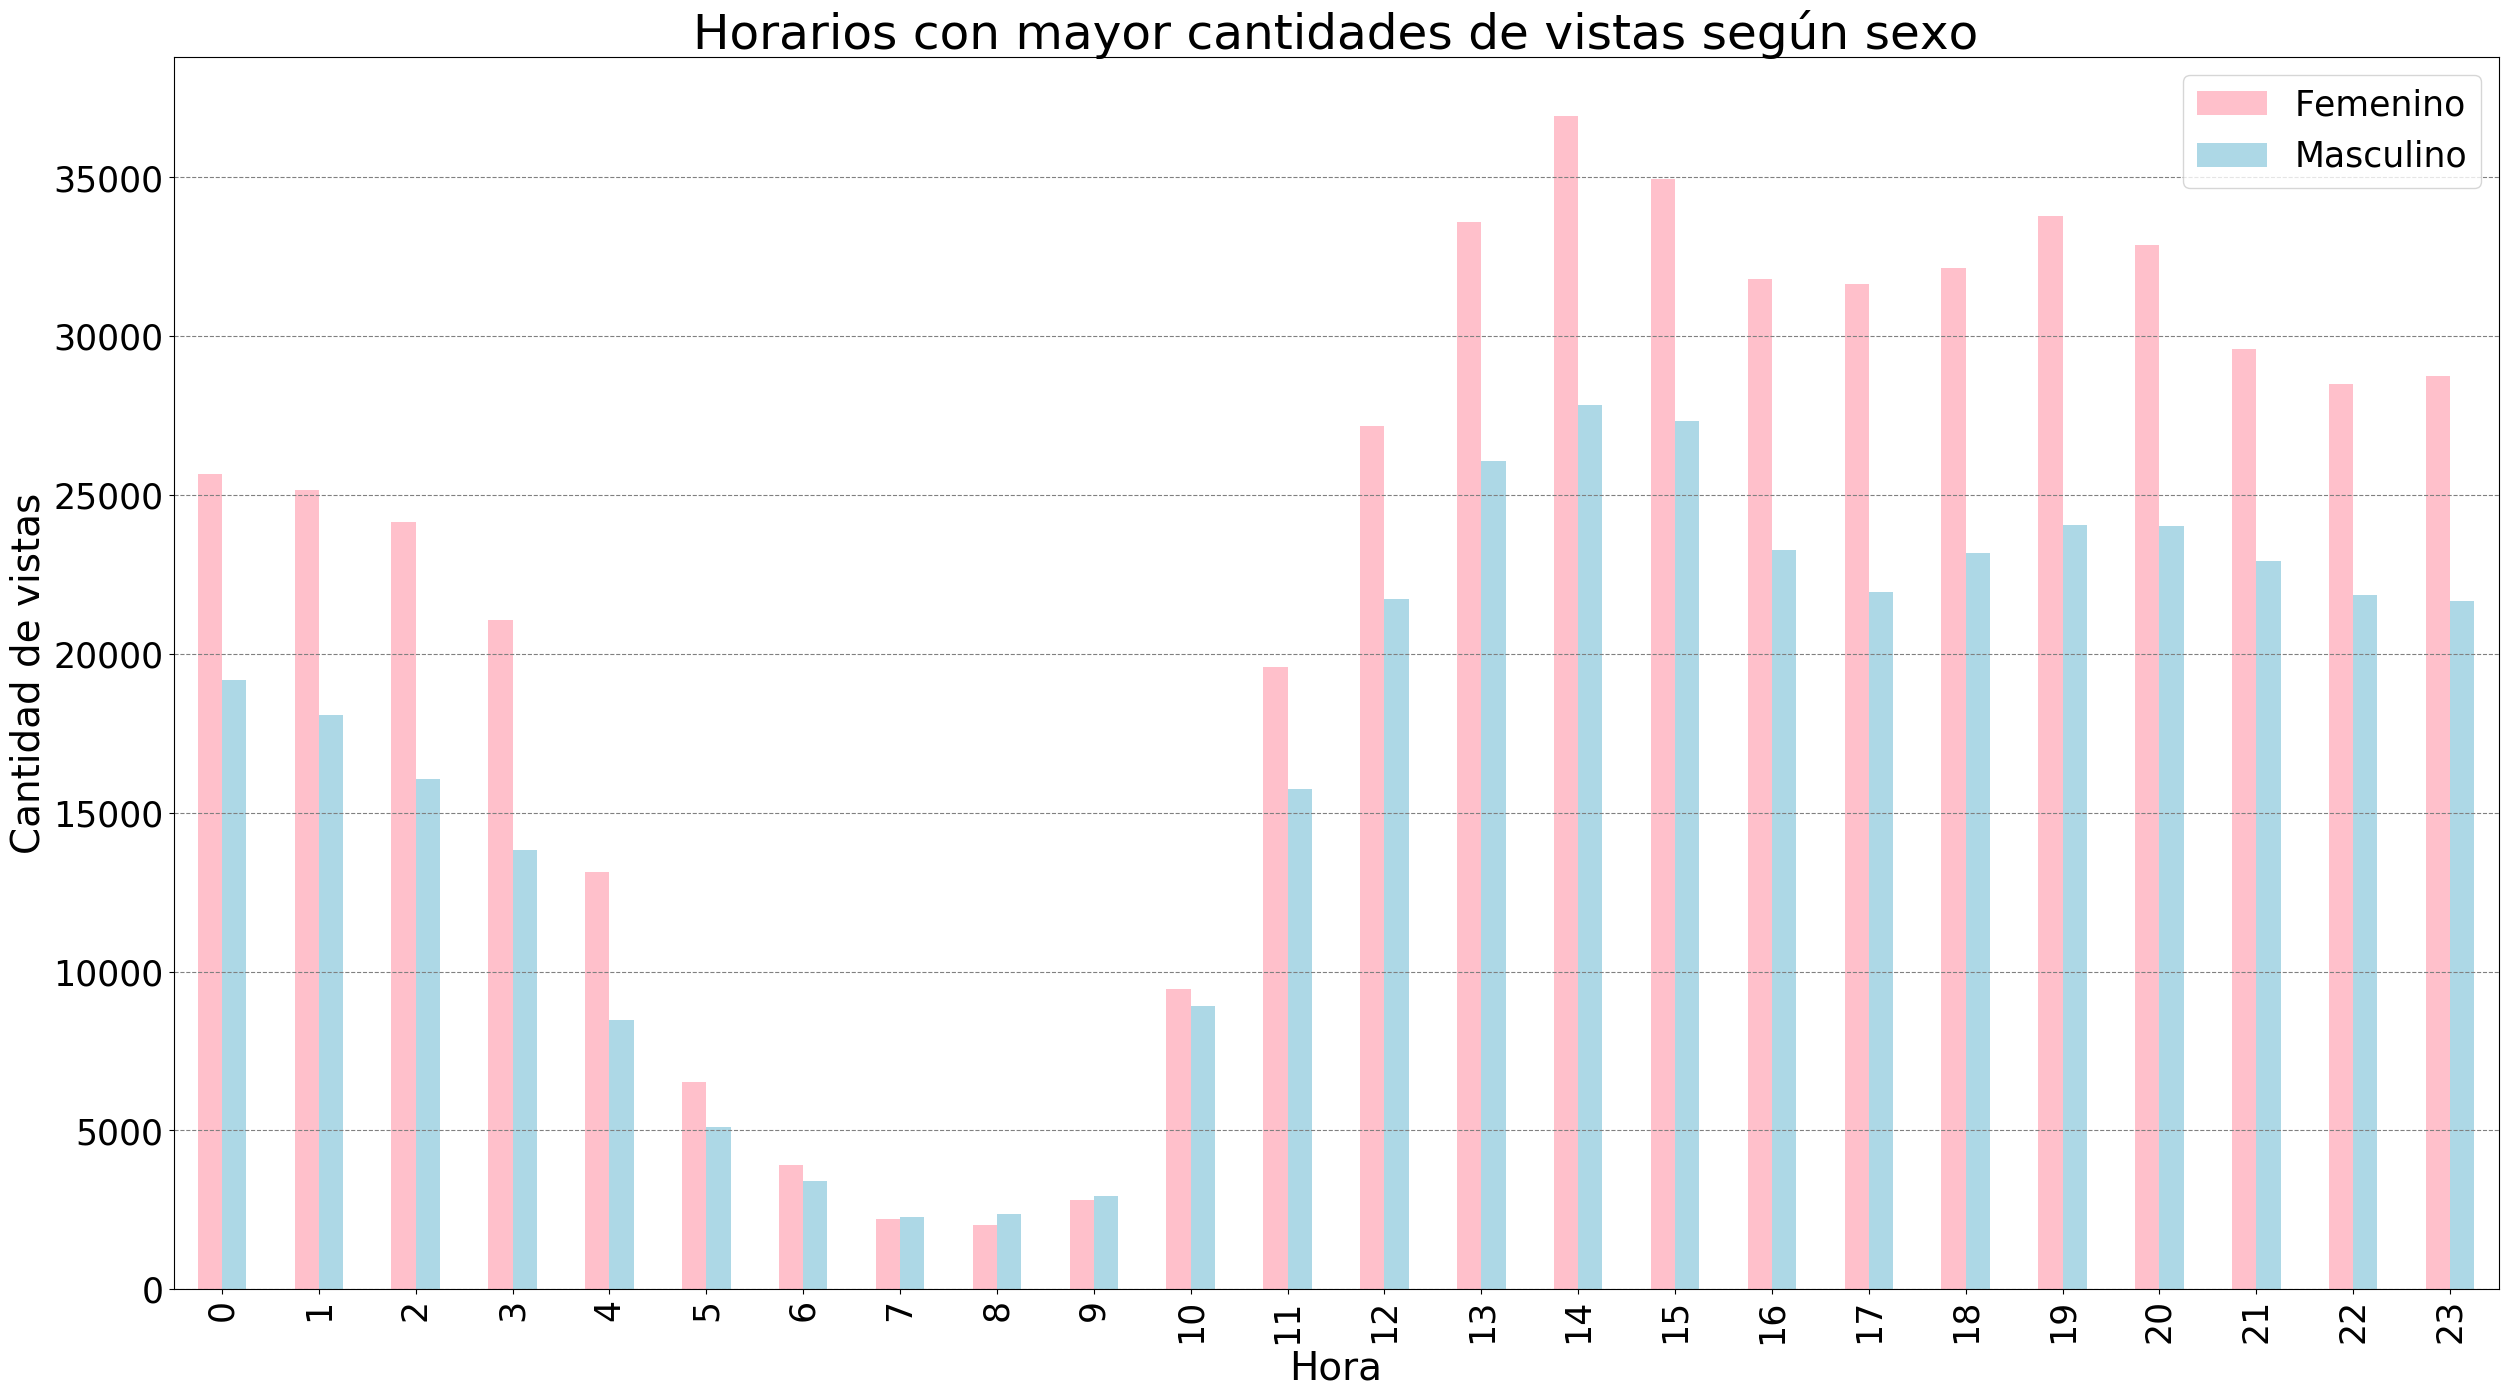

In [50]:
plt = vis_avi.loc[vis_avi.sexo != 'No declara',:]\
    .groupby(['hora','sexo']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='sexo',values='cant')

plt = plt.plot(kind = 'bar', color = ['pink','lightblue'], figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de vistas', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de vistas según sexo', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray')
plt.xaxis.grid(False);

In [51]:
def categorizar_edad(x):
    if (x <= 21):
        return '21 o menos'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    return '40 o más'

vis_avi['rango_edad2'] = vis_avi['edad'].apply(lambda x: categorizar_edad(x))

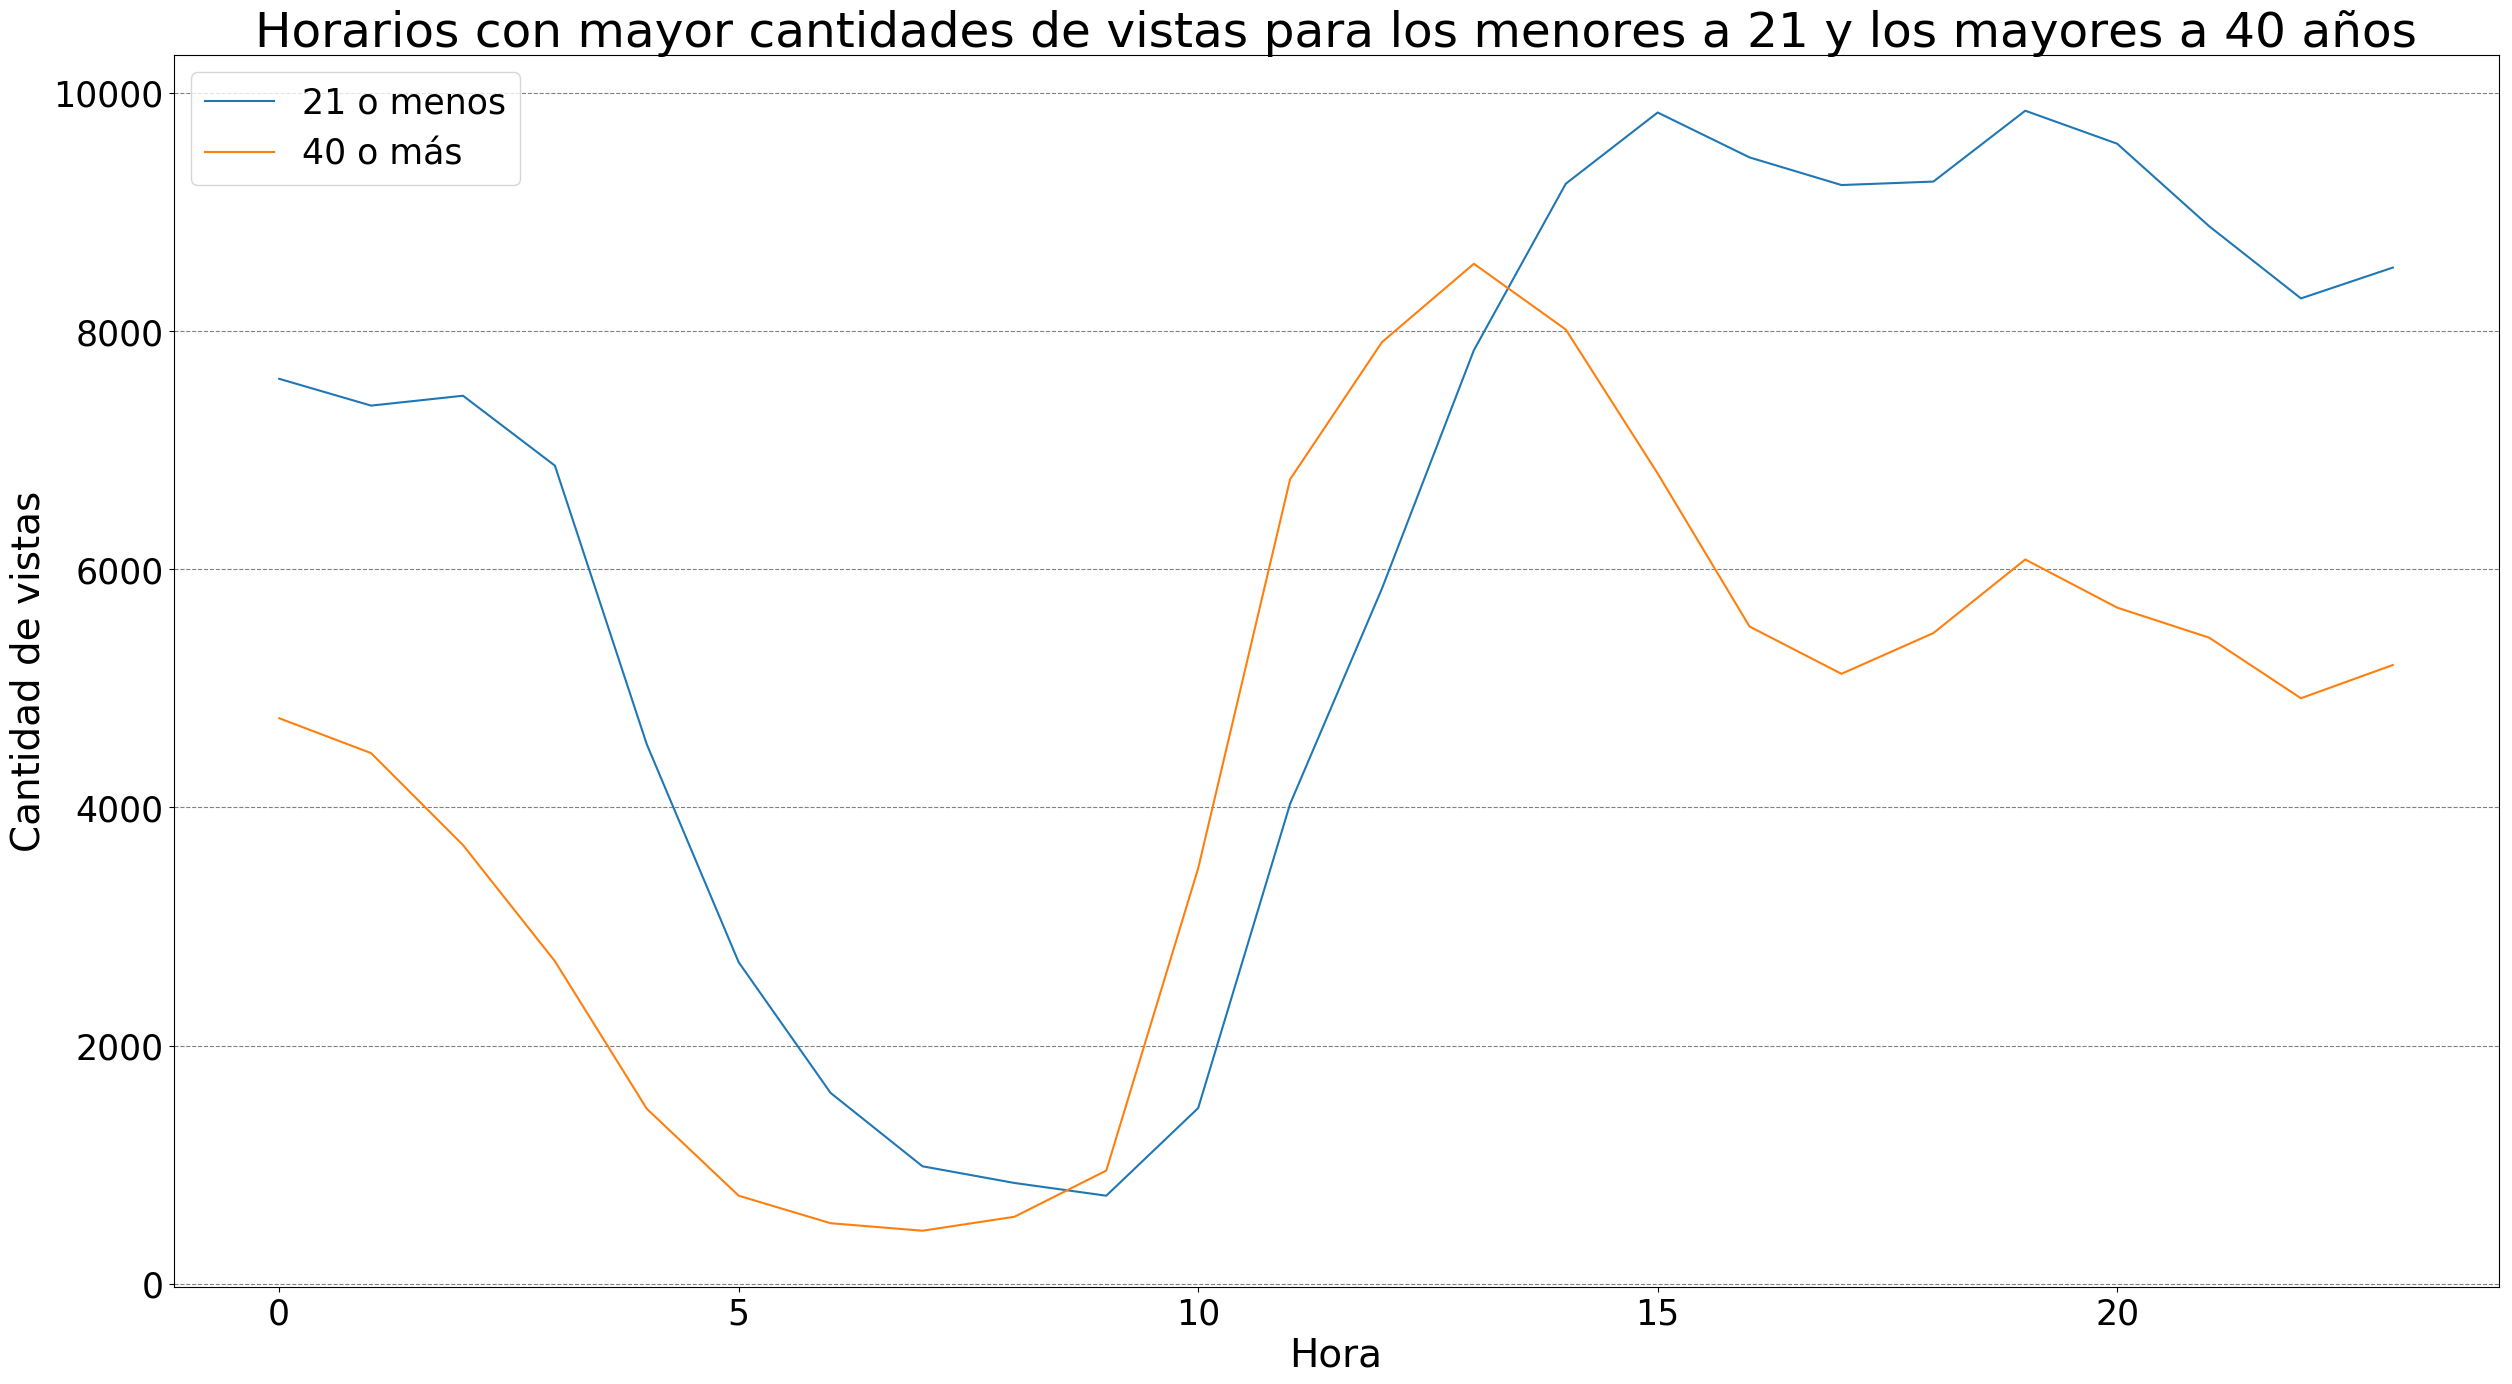

In [52]:
plt = vis_avi.loc[((vis_avi.rango_edad2 == '21 o menos') | (vis_avi.rango_edad2 == '40 o más')),:]\
    .groupby(['hora','rango_edad2']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='rango_edad2',values='cant')

plt = plt.plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Hora', fontsize = 28)
plt.set_ylabel('Cantidad de vistas', fontsize = 28)
plt.set_title('Horarios con mayor cantidades de vistas para los menores a 21 y los mayores a 40 años', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray')
plt.xaxis.grid(False);

### Rangos horarios con más postulaciones

In [53]:
postulaciones['hora'] = postulaciones['fechapostulacion'].dt.hour
postulaciones.head()

,idaviso,idpostulante,fechapostulacion,num_dia,num_mes,num_semana,hora
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3,16
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6,9
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8,9
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8,9
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4,18


In [54]:
#postulaciones = pd.merge(vistas, avisos_detalle, on='idaviso', how='inner')
postulaciones_det = pd.merge(postulaciones,postulantes,on = 'idpostulante',how='inner')
postulaciones_det.head()

,idaviso,idpostulante,fechapostulacion,num_dia,num_mes,num_semana,hora,fechanacimiento,sexo,edad,nombre,estado,nivel_alcanzado,rango_edad
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3,16,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8,9,1970-12-03,Femenino,47,Secundario,Graduado,1.0,41 a 50
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4,18,1962-12-04,Femenino,55,Universitario,Graduado,3.0,51 o más


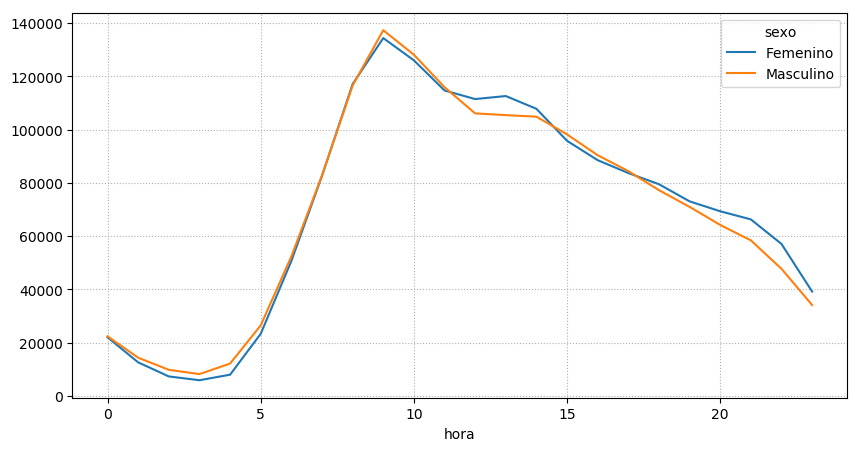

In [55]:
plt = postulaciones_det.loc[postulaciones_det.sexo != 'No declara',:]\
    .groupby(['hora','sexo']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='sexo',values='cant').plot();
plt.grid(linestyle='dotted')

In [56]:
def categorizar_edad(x):
    if (x <= 21):
        return '< 21'
    if (x <= 26):
        return '22 a 26'
    if (x <= 30):
        return '27 a 30'
    if (x <= 35):
        return '31 a 35'
    if (x <= 40):
        return '36 a 40'
    return '> 40'

postulaciones_det['rango_edad2'] = postulaciones_det['edad'].apply(lambda x: categorizar_edad(x))

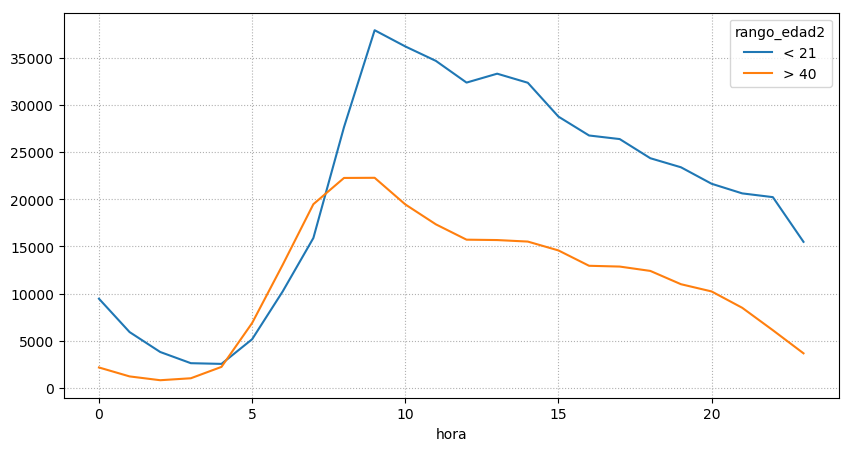

In [57]:
plt = postulaciones_det.loc[((postulaciones_det.rango_edad2 == '< 21') | (postulaciones_det.rango_edad2 == '> 40')),:]\
    .groupby(['hora','rango_edad2']).size().to_frame('cant').reset_index()\
    .pivot(index='hora',columns='rango_edad2',values='cant').plot();
plt.grid(linestyle='dotted')

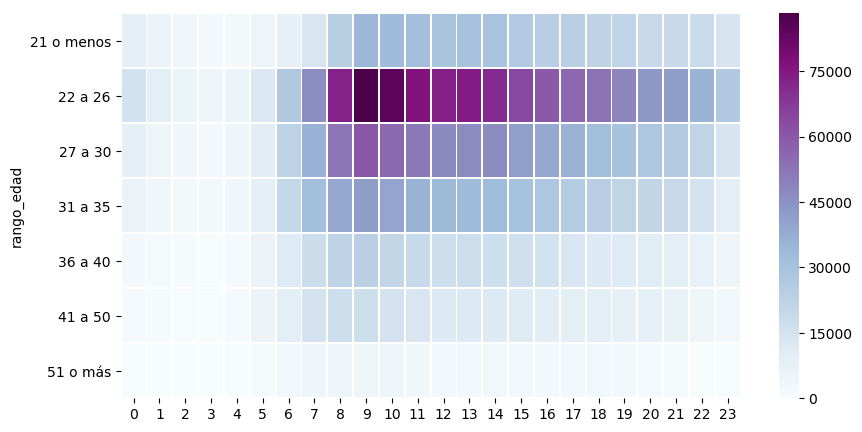

In [58]:
post_edad_hora = postulaciones_det.loc[(postulaciones_det.edad >=18) & (postulaciones_det.edad <=70) ,:]\
    .groupby(['hora','rango_edad']).size().to_frame('cant').reset_index()\
    .pivot(index='rango_edad',columns='hora',values='cant')
post_edad_hora = post_edad_hora.reset_index().rename_axis(None, axis=1)
post_edad_hora.set_index('rango_edad', inplace=True)
post_edad_hora.fillna(0,inplace=True)
sns.heatmap(post_edad_hora, cmap='BuPu', vmin=0, linewidths=0.5, annot=False);


### Correlación entre edad, tipo de trabajo, y horario de vistas y de postulaciones

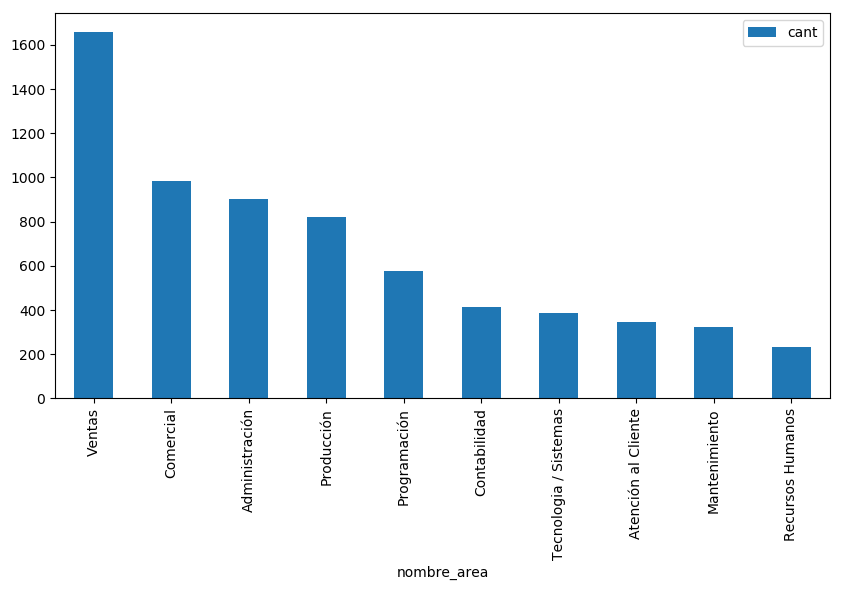

In [59]:
test1 = avisos_detalle.groupby('nombre_area').size().to_frame('cant').sort_values('cant', ascending=False).head(10)
test1.plot.bar();

In [60]:
df = pd.merge(postulaciones, avisos_detalle,on='idaviso', how='inner')

In [61]:
test2 = df.groupby('nombre_area').size().to_frame('cant')

In [62]:
test1.reset_index(inplace=True)
test2.reset_index(inplace=True)

In [63]:
test = pd.merge(test1, test2, on='nombre_area', how='inner')
test.set_index('nombre_area', inplace=True)
test.head()

,cant_x,cant_y
nombre_area,,
Ventas,1659,408148
Comercial,983,216677
Administración,901,291135
Producción,821,277089
Programación,576,8188


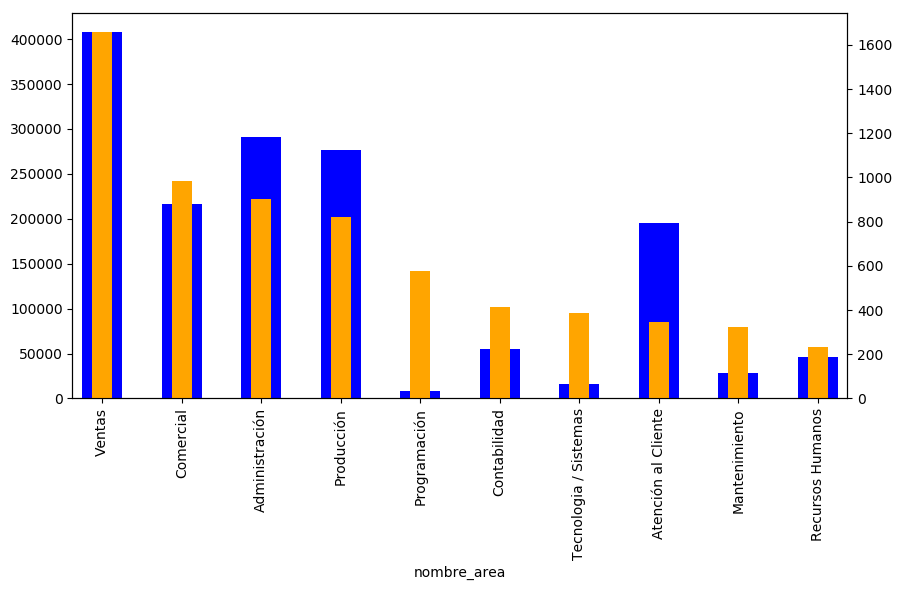

In [64]:
width = 0.5
plt1 = test.head(10)['cant_x'];
plt2 = test.head(10)['cant_y'].plot.bar(color='Blue', width = width);
plt = plt1.plot.bar(color='Orange',ax=plt2,secondary_y=True, width = width/2)

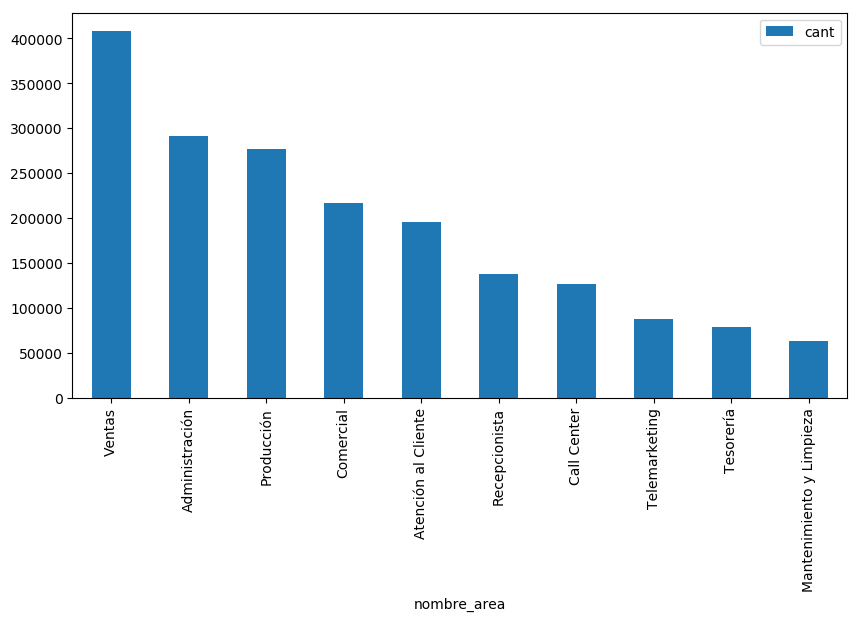

In [65]:
df.groupby('nombre_area').size().to_frame('cant').sort_values('cant',ascending=False).head(10).plot.bar();

### Cantidad de vistas de los postulantes antes de cada postulación

In [66]:
vistas['tipo_transaccion'] = 'V'
vistas.head()

,idaviso,timestamp,idpostulante,hora,tipo_transaccion
0,1111780242,2018-02-23 18:38:13.187,YjVJQ6Z,18,V
1,1112263876,2018-02-23 18:38:14.296,BmVpYoR,18,V
2,1112327963,2018-02-23 18:38:14.329,wVkBzZd,18,V
3,1112318643,2018-02-23 18:38:17.921,OqmP9pv,18,V
4,1111903673,2018-02-23 18:38:18.973,DrpbXDP,18,V


In [67]:
postulaciones['tipo_transaccion'] = 'P'
postulaciones.rename(columns={"fechapostulacion":"timestamp"}, inplace=True)
postulaciones.head(30)

,idaviso,idpostulante,timestamp,num_dia,num_mes,num_semana,hora,tipo_transaccion
0,1112257047,NM5M,2018-01-15 16:22:34,0,1,3,16,P
1,1111920714,NM5M,2018-02-06 09:04:50,1,2,6,9,P
2,1112346945,NM5M,2018-02-22 09:04:47,3,2,8,9,P
3,1112345547,NM5M,2018-02-22 09:04:59,3,2,8,9,P
4,1112237522,5awk,2018-01-25 18:55:03,3,1,4,18,P
5,1112277633,5awk,2018-01-29 13:34:44,0,1,5,13,P
6,1112302347,5awk,2018-02-07 20:49:22,2,2,6,20,P
7,1112291495,5awk,2018-02-07 20:50:13,2,2,6,20,P
8,1112304011,5awk,2018-02-07 20:51:15,2,2,6,20,P
9,1112326289,5awk,2018-02-09 20:24:57,4,2,6,20,P


In [68]:
vis_pos = pd.concat([vistas,postulaciones])

Hay muchas más postulaciones que vistas y no tenemos registros de las vistas anónimas. Suponiendo que antes de postularse se debe primero ver un aviso se concluye que la mayoría de los usuarios ven los avisos primero y se loguean recién al momento de postularse.

### Variedad de las áreas de trabajo a las que se postulan

En esta parte, nos interesa conocer para cada postulante, la cantidad de avisos de distinto tipo se postuló, para asi poder visualizar como varía respecto a la edad del postulante

In [69]:
postulante_aviso = pd.merge(postulaciones, avisos_detalle,on='idaviso', how='inner')

In [70]:
variedad_por_postulante = postulante_aviso.groupby(['idpostulante','nombre_area']).size().to_frame('cant').reset_index()
postulante_postulaciones = pd.merge(postulantes, variedad_por_postulante, on = 'idpostulante',how= 'inner')
postulante_postulaciones = postulante_postulaciones.loc[postulante_postulaciones['edad'] <= 62,:]

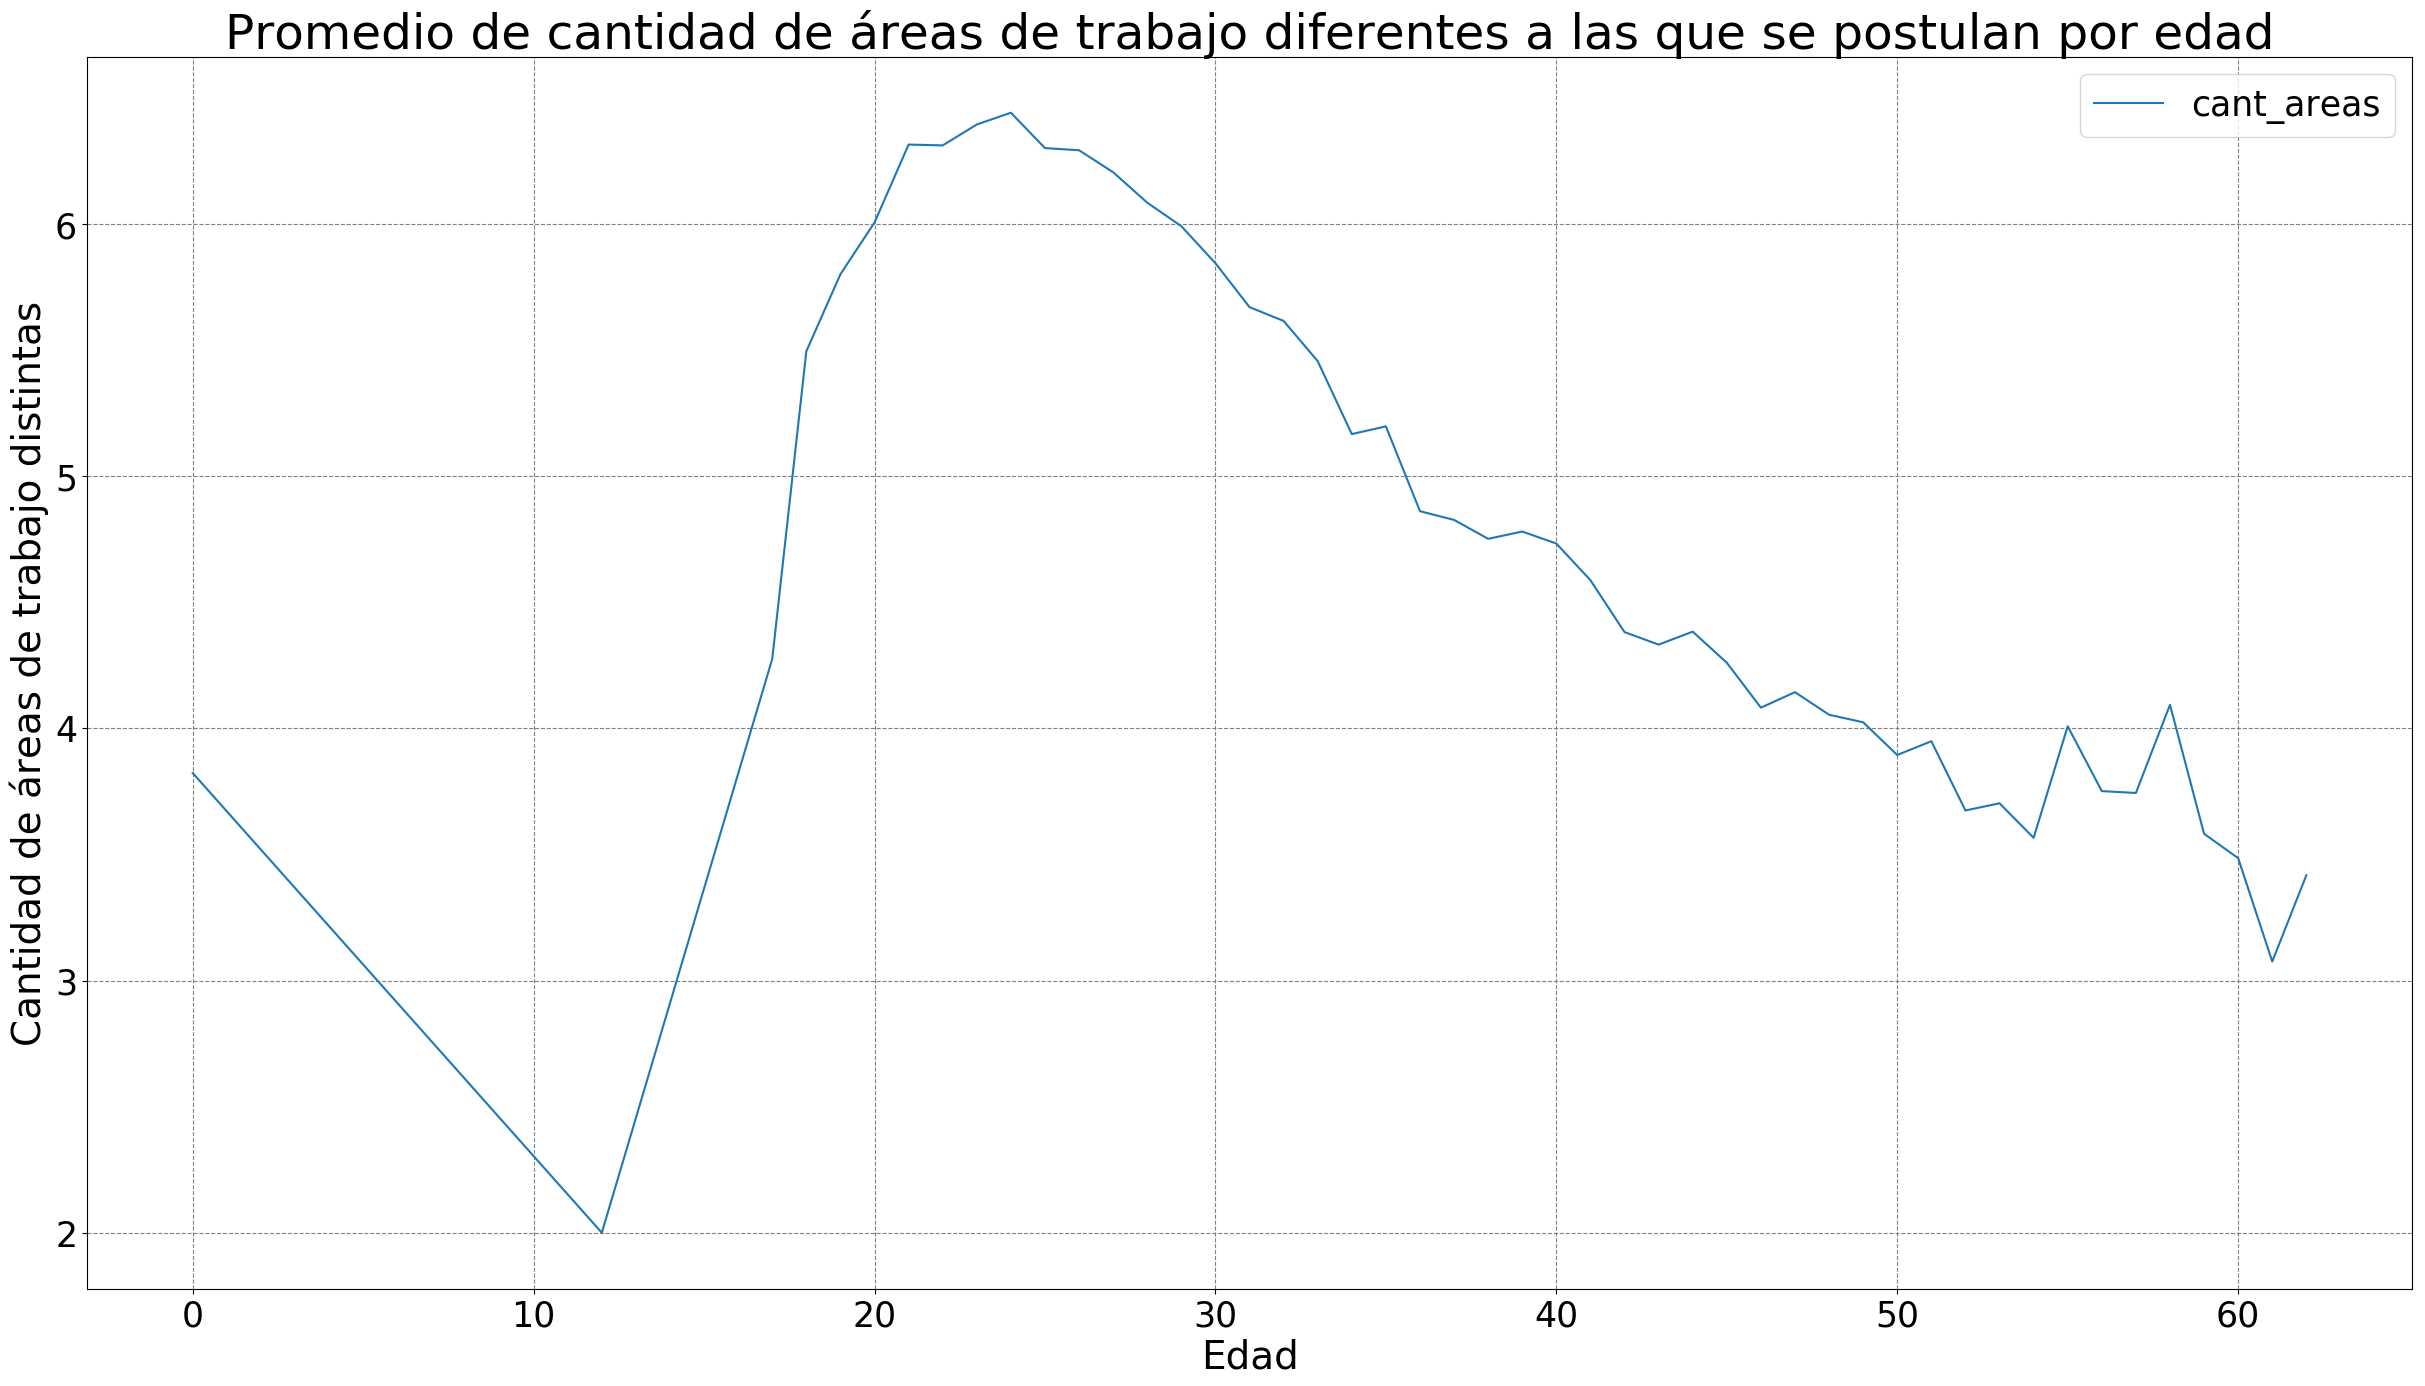

In [72]:
areas_x_edad = postulante_postulaciones.groupby(['edad','idpostulante']).size().to_frame('cant_areas').reset_index()
areas_x_edad = areas_x_edad.groupby('edad')['cant_areas'].mean().to_frame()

plt = areas_x_edad.plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad de áreas de trabajo distintas', fontsize = 28)
plt.set_title('Promedio de cantidad de áreas de trabajo diferentes a las que se postulan por edad', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');

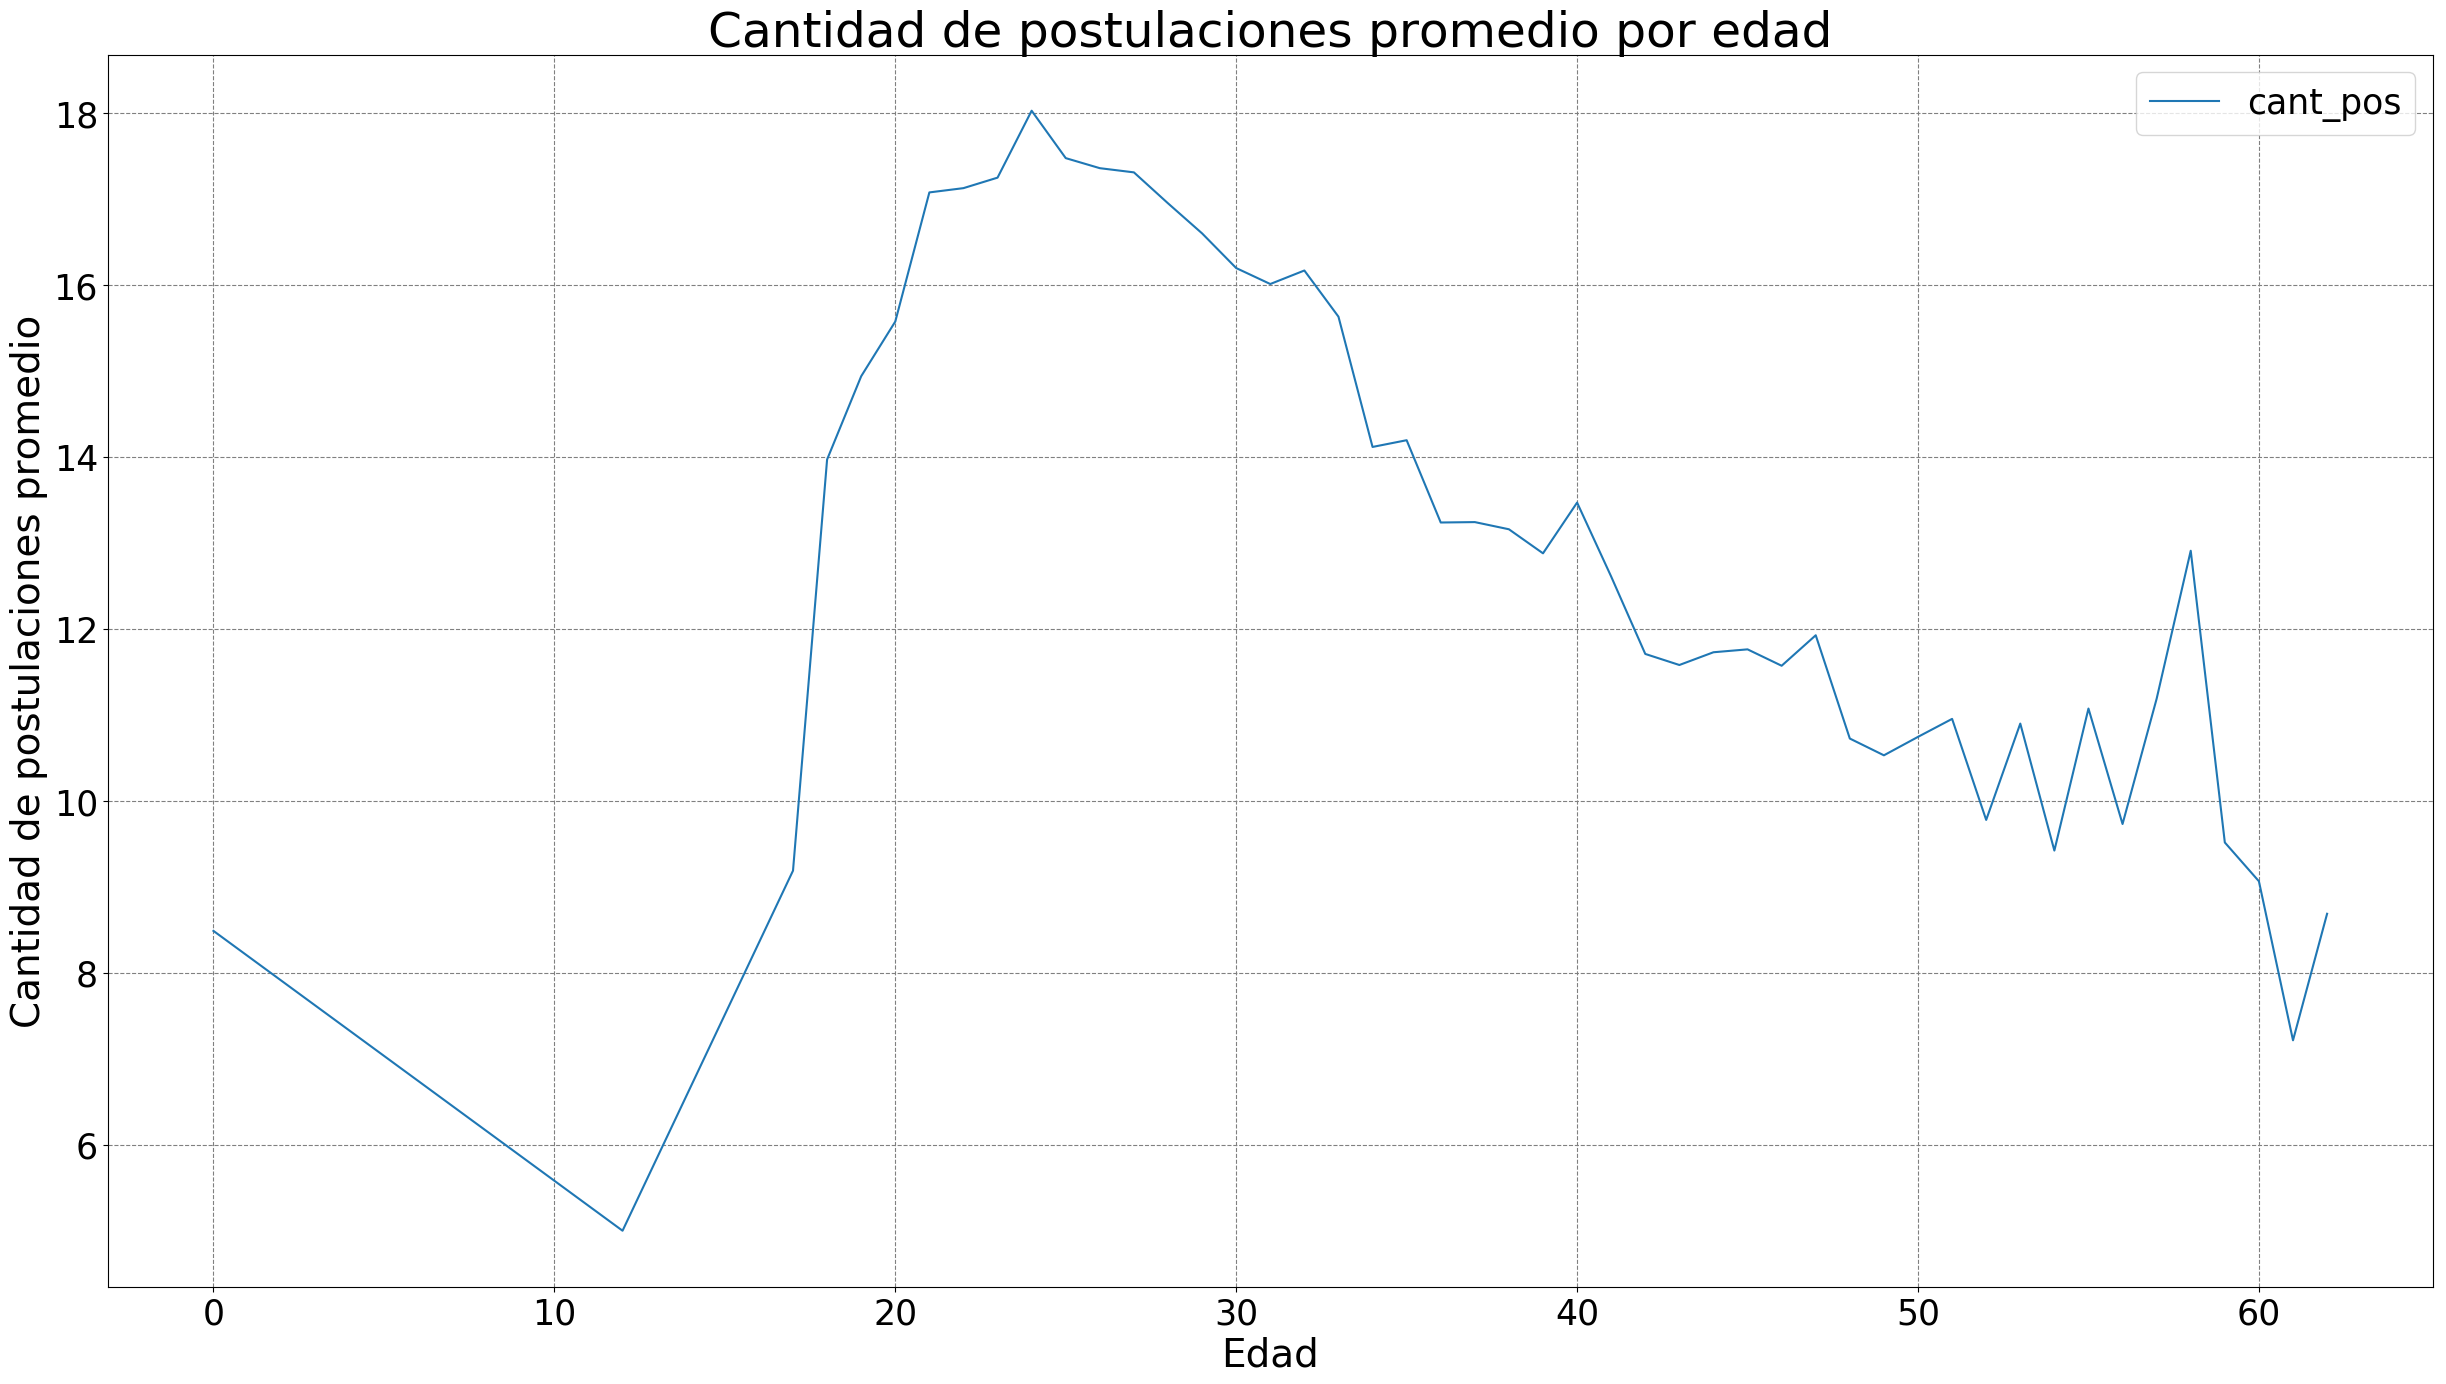

In [73]:
cantidad_por_postulante = postulante_aviso.groupby('idpostulante').size().to_frame('cant_pos').reset_index()
cantidad_por_postulante = pd.merge(postulantes, cantidad_por_postulante, on = 'idpostulante',how= 'inner')
cantidad_por_postulante = cantidad_por_postulante.loc[cantidad_por_postulante['edad'] <= 62,:]
cantidad_x_edad = cantidad_por_postulante.groupby('edad')['cant_pos'].mean()

#cantidad de postulaciones por edad

plt = cantidad_x_edad.to_frame().plot(figsize = (30, 16), fontsize = 25)
plt.set_xlabel('Edad', fontsize = 28)
plt.set_ylabel('Cantidad de postulaciones promedio', fontsize = 28)
plt.set_title('Cantidad de postulaciones promedio por edad', fontsize = 35)
plt.legend(fontsize = 25)
plt.grid(linestyle='dashed', color = 'gray');